# Birth Rates of Humpback and Fin Whales in the Gulf of St. Lawrence

In this study, we'll be assessing how birth rate is changing for Humpback and Fin Whales in the Gulf of St. Lawrence. Birth rate is one measure that tells us how species are changing over time, which helps people decide which species to focus our conservation energies towards. We'll be comparing the average birth rate in 2005-2016 and compare it with 1980-2004.

### Import statement

In [135]:
from IPython.core.debugger import set_trace
import itertools
import logging
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st

import os
import pandas as pd
import pickle
import pymc3 as pm
os.environ["MKL_THREADING_LAYER"] = "GNU"

import re
from scipy import stats
import seaborn as sns
import tempfile
import theano.tensor as tt

# local
from lib.prior_generation import min_age_prior

## Models

### Complete Pooling Model

$$
    \begin{equation}
        \begin{aligned}
        \text{age}_{i,t+1} &= \text{age}_{i,t} + 1 & \text{age increases by one every year} \\
        \text{alive}_{i,t+1} &=
        \begin{cases}
          1, & \text{if age}_{i,t} = 0 \\
          0, & \text{if alive}_{i,t} = 0 \\
          Bernoulli(s_t) & \text{if alive}_{i,t} = 1 \\
        \end{cases} \\
        s_t &\sim Beta(\alpha_{s_t}=1, \beta_{s_t}=1) & \text{survival parameter} \\
        \text{repro_active}_{i,t+1} &=
        \begin{cases}
          0, & \text{if alive}_{i, t+1}=0 \text{ or age}_{i,t+1} < 9 \\
          1 & \text{otherwise}
        \end{cases} \\
        \text{birth}_{i,t+1} &=
        \begin{cases}
          0, & \text{if birth}_{t,i} = 1 \text{ or } \text{repro_active}_{i,t+1} = 0 \\
          Bernoulli(b_t) & \text{otherwise}
        \end{cases} \\
        b_t &\sim Beta(\alpha_{b_t}=1, \beta_{b_t}=1) & \text{birth parameter} \\
        \text{count}_{i,t+1} &=
        \begin{cases}
            0, & \text{if alive}_{i,t+1} = 0 \\
            1 + \text{birth}_{i,t+1} & \text{if} Bernoulli(d_t) = 1
        \end{cases} \\
        d_t &\sim Beta(\alpha_{d_t}=1, \beta_{d_t}=1) & \text{detection parameter} \\
        \end{aligned}
    \end{equation}
$$

### Partial Pooling Model

$$
    \begin{equation}
        \begin{aligned}
        \text{age}_{i,t+1} &= \text{age}_{i,t} + 1 & \text{age increases by one every year} \\
        \text{alive}_{i,t+1} &=
        \begin{cases}
          1, & \text{if age}_{i,t} = 0 \\
          0, & \text{if alive}_{i,t} = 0 \\
          Bernoulli(p_i) & \text{if alive}_{i,t} = 1 \\
        \end{cases} \\
        p_i &\sim Beta(\alpha_{p}, \beta_{p}) & \text{survival parameter} \\
        \alpha_{p} &\sim Exponential(\lambda=0.1) \\
        \beta_{p} &\sim Exponential(\lambda=0.1) \\
        \text{repro_active}_{i,t+1} &=
        \begin{cases}
          0, & \text{if alive}_{i, t+1}=0 \text{ or age}_{i,t+1} < 9 \\
          1 & \text{otherwise}
        \end{cases} \\
        \text{birth}_{i,t+1} &=
        \begin{cases}
          0, & \text{if birth}_{t,i} = 1 \text{ or } \text{alive}_{i,t+1}=0 \\
          Bernoulli(b_i) & \text{otherwise}
        \end{cases} \\
        b_i &\sim Beta(\alpha_{b}, \beta_{b}) & \text{birth parameter} \\
        \alpha_{b} &\sim Exponential(\lambda=0.1) \\
        \beta_{b} &\sim Exponential(\lambda=0.1) \\
        \text{count}_{i,t+1} &=
        \begin{cases}
            0, & \text{if alive}_{i,t+1} = 0 \\
            1 + \text{birth}_{i,t+1} & \text{if} Bernoulli(c_i) = 1
        \end{cases} \\
        c_i &\sim Beta(\alpha_{c}, \beta_{c}) & \text{detection parameter} \\
        \alpha_{c} &\sim Exponential(\lambda=0.1) \\
        \beta_{c} &\sim Exponential(\lambda=0.1) \\
        \end{aligned}
    \end{equation}
$$

### Time-Varying Partially Pooled Model

Below we display the causal diagram. Each node represents a variable in the format of $V_{a,b}$, where $a$ stands for the individual, $b$ is the year, and $V$ is the variable. Individuals $i$ and $j$ are represented in this graph. The white nodes are nodes that are shared amongst individuals.

![Time-Varying Partially-Pooled Model](../img/time-varying-partially-pooled.png)

In terms of probability distributions, here's the specification of the model:

$$
    \begin{equation}
        \begin{aligned}
        \text{age}_{i,t+1} &= \text{age}_{i,t} + 1 & \text{age increases by one every year} \\
        \text{alive}_{i,t+1} &=
        \begin{cases}
          1, & \text{if age}_{i,t} = 0 \\
          0, & \text{if alive}_{i,t} = 0 \\
          Bernoulli(p_{i,t+1}) & \text{if alive}_{i,t} = 1 \\
        \end{cases} \\
        p_{i,t+1} &\sim Beta(\alpha_{p_{i,t+1}}, \beta_{p_{i,t+1}}) & \text{survival parameter} \\
        \alpha_{p_{i,t+1}} &\sim Posterior(\alpha_{p_{i,t}}) \\
        \beta_{p_{i,t+1}} &\sim Posterior(\beta_{p_{i,t}}) \\
        \alpha_{p_{i,t=0}} &\sim Exponential(\lambda=0.1) \\
        \beta_{p_{i,t=0}} &\sim Exponential(\lambda=0.1) \\
        \text{repro_active}_{i,t+1} &=
        \begin{cases}
          0, & \text{if alive}_{i, t+1}=0 \text{ or age}_{i,t+1} < 9 \\
          1 & \text{otherwise}
        \end{cases} \\
        \text{birth}_{i,t+1} &=
        \begin{cases}
          0, & \text{if birth}_{t,i} = 1 \text{ or } \text{alive}_{i,t+1}=0 \\
          Bernoulli(b_{i,t}) & \text{otherwise}
        \end{cases} \\
        b_i &\sim Beta(\alpha_{b}, \beta_{b}) & \text{birth parameter} \\
        \alpha_{b_{i,t+1}} &\sim Posterior(\alpha_{b_{i,t}}) \\
        \beta_{b_{i,t+1}} &\sim Posterior(\beta_{b_{i,t}}) \\
        \alpha_{b_{i,t=0}} &\sim Exponential(\lambda=0.1) \\
        \beta_{b_{i,t=0}} &\sim Exponential(\lambda=0.1) \\
        \text{count}_{i,t+1} &=
        \begin{cases}
            0, & \text{if alive}_{i,t+1} = 0 \\
            1 + \text{birth}_{i,t+1} & \text{if} Bernoulli(c_i) = 1
        \end{cases} \\
        c_i &\sim Beta(\alpha_{c_{i,t}}, \beta_{c_{i,t}}) & \text{detection parameter} \\
        \alpha_{c_{i,t+1}} &\sim Posterior(\alpha_{c_{i,t}}) \\
        \beta_{c_{i,t+1}} &\sim Posterior(\beta_{c_{i,t}}) \\
        \alpha_{c_{i,t=0}} &\sim Exponential(\lambda=0.1) \\
        \beta_{c_{i,t=0}} &\sim Exponential(\lambda=0.1) \\
        \end{aligned}
    \end{equation}
$$

## Data Cleaning

In [2]:
calving_data = pd.read_excel('./data/females_calving_2016 up to date.xlsx')
calving_data

MICS   HWC numbers   80  81   82   83                    84   85   86  \
0    H002          3229  1.0 NaN  NaN  1.0                     1  NaN  NaN   
1    H004          1422  NaN NaN  1.0  2.0                   NaN  NaN  NaN   
2    H008          1417  NaN NaN  2.0  1.0                     1  2.0  NaN   
3    H009          1419  NaN NaN  1.0  NaN                   NaN  NaN  NaN   
4    H035          2088  NaN NaN  1.0  NaN                   NaN  NaN  NaN   
5    H042          1451  NaN NaN  NaN  1.0                     1  NaN  NaN   
6    H044          1424  NaN NaN  1.0  1.0                   NaN  1.0  1.0   
7    H065          7002  NaN NaN  NaN  NaN                   NaN  1.0  NaN   
8    H067          7014  NaN NaN  NaN  NaN                   NaN  NaN  NaN   
9    H102           NaN  NaN NaN  NaN  NaN                     1  1.0  NaN   
10   H103          0274  NaN NaN  NaN  NaN                     1  NaN  NaN   
11   H109          1492  NaN NaN  NaN  NaN                   NaN  1.0  NaN   
12   H118          1491  NaN NaN  NaN  NaN                   NaN  1.0  NaN   
13   H135          3090  NaN NaN  NaN  NaN                   NaN  NaN  NaN   
14   H137          7013  NaN NaN  NaN  NaN                   NaN  NaN  NaN   
15   H140          7015  NaN NaN  NaN  NaN                   NaN  NaN  NaN   
16   H141          0449  NaN NaN  NaN  NaN                   NaN  NaN  NaN   
17   H144          7008  NaN NaN  NaN  NaN                   NaN  NaN  NaN   
18   H147          7019  NaN NaN  NaN  NaN                   NaN  NaN  NaN   
19   H148          2319  NaN NaN  NaN  NaN                   NaN  NaN  NaN   
20   H150          7020  NaN NaN  NaN  NaN                   NaN  NaN  NaN   
21   H157          7018  NaN NaN  NaN  NaN                   NaN  NaN  NaN   
22   H164          7032  NaN NaN  NaN  NaN                   NaN  NaN  NaN   
23   H166          7028  NaN NaN  NaN  NaN                   NaN  NaN  NaN   
24   H168          1452  NaN NaN  1.0  NaN                   NaN  NaN  NaN   
25   H169          7029  NaN NaN  NaN  NaN                   NaN  NaN  NaN   
26   H212          7066  NaN NaN  NaN  NaN                   NaN  NaN  NaN   
27   H216          7068  NaN NaN  NaN  1.0                   NaN  NaN  NaN   
28   H228          7070  NaN NaN  NaN  NaN                   NaN  NaN  NaN   
29   H231          7116  NaN NaN  NaN  NaN                   NaN  NaN  NaN   
..    ...           ...  ...  ..  ...  ...                   ...  ...  ...   
97   H712           NaN  NaN NaN  NaN  NaN                   NaN  NaN  NaN   
98   H716           NaN  NaN NaN  NaN  NaN                   NaN  NaN  NaN   
99   H719           NaN  NaN NaN  NaN  NaN                   NaN  NaN  NaN   
100  H721           NaN  NaN NaN  NaN  NaN                   NaN  NaN  NaN   
101  H725           NaN  NaN NaN  NaN  NaN                   NaN  NaN  NaN   
102  H728           NaN  NaN NaN  NaN  NaN                   NaN  NaN  NaN   
103  H729           NaN  NaN NaN  NaN  NaN                   NaN  NaN  NaN   
104  H731           NaN  NaN NaN  NaN  NaN                   NaN  NaN  NaN   
105  H738           NaN  NaN NaN  NaN  NaN                   NaN  NaN  NaN   
106  H745           NaN  NaN NaN  NaN  NaN                   NaN  NaN  NaN   
107  H747           NaN  NaN NaN  NaN  NaN                   NaN  NaN  NaN   
108  H748           NaN  NaN NaN  NaN  NaN                   NaN  NaN  NaN   
109  H752           NaN  NaN NaN  NaN  NaN                   NaN  NaN  NaN   
110  H753           NaN  NaN NaN  NaN  NaN                   NaN  NaN  NaN   
111  H782           NaN  NaN NaN  NaN  NaN                   NaN  NaN  NaN   
112  H788           NaN  NaN NaN  NaN  NaN                   NaN  NaN  NaN   
113  H798           NaN  NaN NaN  NaN  NaN                   NaN  NaN  NaN   
114   NaN  new cow 2016  NaN NaN  NaN  NaN                   NaN  NaN  NaN   
115   NaN           NaN  NaN NaN  NaN  NaN                   NaN  NaN  NaN   
116   NaN           NaN  Na

### Only look at those rows with ids

In [3]:
with_ids = calving_data[calving_data['MICS'].notnull() | calving_data['HWC numbers'].notnull()]
# generate our own id for each whale, which is a composite of MICS and HWC numbers.
with_ids.index = with_ids['MICS'].astype(str) + '-' + with_ids['HWC numbers'].astype(str)
with_ids

MICS   HWC numbers   80  81   82   83   84   85   86   87  \
H002-3229         H002          3229  1.0 NaN  NaN  1.0    1  NaN  NaN  1.0   
H004-1422         H004          1422  NaN NaN  1.0  2.0  NaN  NaN  NaN  NaN   
H008-1417         H008          1417  NaN NaN  2.0  1.0    1  2.0  NaN  NaN   
H009-1419         H009          1419  NaN NaN  1.0  NaN  NaN  NaN  NaN  1.0   
H035-2088         H035          2088  NaN NaN  1.0  NaN  NaN  NaN  NaN  NaN   
H042-1451         H042          1451  NaN NaN  NaN  1.0    1  NaN  NaN  1.0   
H044-1424         H044          1424  NaN NaN  1.0  1.0  NaN  1.0  1.0  1.0   
H065-7002         H065          7002  NaN NaN  NaN  NaN  NaN  1.0  NaN  1.0   
H067-7014         H067          7014  NaN NaN  NaN  NaN  NaN  NaN  NaN  NaN   
H102-nan          H102           NaN  NaN NaN  NaN  NaN    1  1.0  NaN  NaN   
H103-0274         H103          0274  NaN NaN  NaN  NaN    1  NaN  NaN  NaN   
H109-1492         H109          1492  NaN NaN  NaN  NaN  NaN  1.0  NaN  1.0   
H118-1491         H118          1491  NaN NaN  NaN  NaN  NaN  1.0  NaN  NaN   
H135-3090         H135          3090  NaN NaN  NaN  NaN  NaN  NaN  NaN  NaN   
H137-7013         H137          7013  NaN NaN  NaN  NaN  NaN  NaN  NaN  NaN   
H140-7015         H140          7015  NaN NaN  NaN  NaN  NaN  NaN  NaN  NaN   
H141-0449         H141          0449  NaN NaN  NaN  NaN  NaN  NaN  NaN  NaN   
H144-7008         H144          7008  NaN NaN  NaN  NaN  NaN  NaN  NaN  NaN   
H147-7019         H147          7019  NaN NaN  NaN  NaN  NaN  NaN  NaN  NaN   
H148-2319         H148          2319  NaN NaN  NaN  NaN  NaN  NaN  NaN  NaN   
H150-7020         H150          7020  NaN NaN  NaN  NaN  NaN  NaN  NaN  NaN   
H157-7018         H157          7018  NaN NaN  NaN  NaN  NaN  NaN  NaN  NaN   
H164-7032         H164          7032  NaN NaN  NaN  NaN  NaN  NaN  NaN  NaN   
H166-7028         H166          7028  NaN NaN  NaN  NaN  NaN  NaN  NaN  NaN   
H168-1452         H168          1452  NaN NaN  1.0  NaN  NaN  NaN  NaN  NaN   
H169-7029         H169          7029  NaN NaN  NaN  NaN  NaN  NaN  NaN  NaN   
H212-7066         H212          7066  NaN NaN  NaN  NaN  NaN  NaN  NaN  NaN   
H216-7068         H216          7068  NaN NaN  NaN  1.0  NaN  NaN  NaN  NaN   
H228-7070         H228          7070  NaN NaN  NaN  NaN  NaN  NaN  NaN  NaN   
H231-7116         H231          7116  NaN NaN  NaN  NaN  NaN  NaN  NaN  NaN   
...                ...           ...  ...  ..  ...  ...  ...  ...  ...  ...   
H689-nan          H689           NaN  NaN NaN  NaN  NaN  NaN  NaN  NaN  NaN   
H692-nan          H692           NaN  NaN NaN  NaN  NaN  NaN  NaN  NaN  NaN   
H693-nan          H693           NaN  NaN NaN  NaN  NaN  NaN  NaN  NaN  NaN   
H694-nan          H694           NaN  NaN NaN  NaN  NaN  NaN  NaN  NaN  NaN   
H697-nan          H697           NaN  NaN NaN  NaN  NaN  NaN  NaN  NaN  NaN   
H700-nan          H700           NaN  NaN NaN  NaN  NaN  NaN  NaN  NaN  NaN   
H703-nan          H703           NaN  NaN NaN  NaN  NaN  NaN  NaN  NaN  NaN   
H704-nan          H704           NaN  NaN NaN  NaN  NaN  NaN  NaN  NaN  NaN   
H705-nan          H705           NaN  NaN NaN  NaN  NaN  NaN  NaN  NaN  NaN   
H706-nan          H706           NaN  NaN NaN  NaN  NaN  NaN  NaN  NaN  NaN   
H710-nan          H710           NaN  NaN NaN  NaN  NaN  NaN  NaN  NaN  NaN   
H711-nan          H711           NaN  NaN NaN  NaN  NaN  NaN  NaN  NaN  NaN   
H712-nan          H712           NaN  NaN NaN  NaN  NaN  NaN  NaN  NaN  NaN   
H716-nan          H716           NaN  NaN NaN  NaN  NaN  NaN  NaN  NaN  NaN   
H719-nan          H719           NaN  NaN NaN  NaN  NaN  NaN  NaN  NaN  NaN   
H721-nan          H721           NaN  NaN NaN  NaN  NaN  NaN  NaN  NaN  NaN   
H725-nan          H725           NaN  NaN NaN  NaN  NaN  NaN  NaN  NaN  NaN   
H728-nan          H728           NaN  NaN NaN  NaN  NaN  NaN  NaN  NaN  NaN   
H729-nan          H729           NaN  NaN NaN  NaN  NaN  NaN  NaN  N

In [4]:
def yearify(x):
    """
        Convert strings to years.
        
        The data only has years showing last two digits. We want to convert 
        them into a four-digit number.
        
        Parameters:
        
            x: string, two digits
            
        Returns:
        
            integer year with four digits.
    """
    _x = int(x)
    if _x >= 80:
        return 1900 + _x
    else:
        return 2000 + _x

### Make columns four-digit years

This will enable us to add 1 to the year to get the next year. Previously this doesn't necessarily lead to the correct result. For example 1999 was represented as 99. 99 + 1 = 100 instead of 00 (which stood for 2000).

In [5]:
# Remove some columns we don't care about
unsorted_years_xx = list(set(with_ids.columns) - set(['MICS', 'HWC numbers', 'Unnamed: 39']))

# Get the dataframe where columns are of interest
with_ids_unsorted_years_xx = with_ids[unsorted_years_xx]

# Convert each column into a stringified four-digit year
unsorted_years_xxxx = list(
        map(
            lambda x: str(x),
            map(
                yearify,
                with_ids_unsorted_years_xx.columns
            )
        )
    )

with_ids_unsorted_years_xx.columns = unsorted_years_xxxx
with_ids_unsorted_years_xx

2011  2012  2016  2010  2014  2003 2006  2005  2002  2009  \
H002-3229          1.0   1.0   1.0   1.0   1.0   2.0    1   1.0   1.0   1.0   
H004-1422          NaN   NaN   NaN   1.0   NaN   1.0    1   2.0   NaN   1.0   
H008-1417          1.0   1.0   2.0   1.0   1.0   1.0    2   1.0   NaN   1.0   
H009-1419          1.0   1.0   1.0   1.0   1.0   2.0    1   2.0   1.0   1.0   
H035-2088          NaN   NaN   NaN   NaN   NaN   1.0  NaN   NaN   NaN   NaN   
H042-1451          1.0   NaN   2.0   1.0   1.0   1.0    1   2.0   1.0   1.0   
H044-1424          NaN   NaN   NaN   2.0   NaN   1.0    1   1.0   NaN   NaN   
H065-7002          NaN   NaN   NaN   NaN   NaN   NaN  NaN   NaN   NaN   NaN   
H067-7014          NaN   NaN   NaN   NaN   NaN   1.0  NaN   1.0   NaN   NaN   
H102-nan           1.0   1.0   1.0   NaN   1.0   NaN  NaN   2.0   NaN   NaN   
H103-0274          NaN   NaN   NaN   NaN   NaN   NaN  NaN   NaN   NaN   NaN   
H109-1492          1.0   1.0   1.0   2.0   NaN   2.0    1   2.0   1.0   1.0   
H118-1491          NaN   NaN   1.0   NaN   NaN   NaN  NaN   2.0   NaN   1.0   
H135-3090          NaN   NaN   NaN   NaN   NaN   NaN  NaN   NaN   NaN   NaN   
H137-7013          NaN   NaN   NaN   NaN   NaN   NaN  NaN   NaN   NaN   NaN   
H140-7015          1.0   NaN   1.0   1.0   1.0   2.0    1   2.0   1.0   1.0   
H141-0449          1.0   1.0   1.0   1.0   NaN   1.0    1   2.0   1.0   1.0   
H144-7008          1.0   NaN   NaN   2.0   NaN   1.0  NaN   2.0   NaN   1.0   
H147-7019          NaN   NaN   NaN   NaN   NaN   1.0  NaN   1.0   NaN   NaN   
H148-2319          NaN   NaN   NaN   NaN   NaN   NaN  NaN   NaN   NaN   NaN   
H150-7020          NaN   NaN   NaN   2.0   NaN   2.0    1   1.0   1.0   1.0   
H157-7018          NaN   NaN   NaN   NaN   NaN   NaN  NaN   NaN   NaN   NaN   
H164-7032          NaN   NaN   NaN   NaN   NaN   1.0  NaN   NaN   2.0   1.0   
H166-7028          NaN   1.0   1.0   1.0   NaN   2.0    1   2.0   1.0   NaN   
H168-1452          2.0   1.0   1.0   1.0   1.0   1.0    2   1.0   NaN   1.0   
H169-7029          NaN   NaN   NaN   NaN   NaN   NaN  NaN   NaN   NaN   NaN   
H212-7066          NaN   NaN   NaN   NaN   NaN   NaN  NaN   2.0   1.0   NaN   
H216-7068          NaN   NaN   NaN   NaN   NaN   NaN  NaN   NaN   NaN   NaN   
H228-7070          1.0   1.0   1.0   2.0   NaN   1.0    1   2.0   1.0   1.0   
H231-7116          NaN   NaN   NaN   NaN   NaN   NaN  NaN   NaN   NaN   NaN   
...                ...   ...   ...   ...   ...   ...  ...   ...   ...   ...   
H689-nan           1.0   1.0   1.0   1.0   1.0   NaN  NaN   NaN   NaN   1.0   
H692-nan           1.0   1.0   1.0   1.0   1.0   NaN  NaN   NaN   NaN   1.0   
H693-nan           NaN   NaN   NaN   NaN   NaN   NaN  NaN   NaN   NaN   NaN   
H694-nan           NaN   NaN   1.0   NaN   NaN   NaN  NaN   NaN   NaN   NaN   
H697-nan           NaN   NaN   NaN   NaN   NaN   NaN  NaN   NaN   NaN   NaN   
H700-nan           NaN   NaN   NaN   NaN   NaN   NaN  NaN   NaN   NaN   NaN   
H703-nan           NaN   NaN   NaN   NaN   NaN   NaN  NaN   NaN   NaN   1.0   
H704-nan           1.0   NaN   1.0   NaN   NaN   NaN  NaN   NaN   NaN   1.0   
H705-nan           1.0   NaN   1.0   1.0   NaN   NaN  NaN   NaN   NaN   NaN   
H706-nan           1.0   1.0   1.0   1.0   NaN   NaN  NaN   NaN   NaN   NaN   
H710-nan           1.0   1.0   NaN   NaN   1.0   NaN  NaN   NaN   NaN   1.0   
H711-nan           NaN   NaN   NaN   NaN   NaN   NaN  NaN   NaN   NaN   NaN   
H712-nan           NaN   NaN   NaN   NaN   NaN   NaN  NaN   NaN   NaN   NaN   
H716-nan           NaN   NaN   NaN   NaN   NaN   NaN  NaN   NaN   NaN   NaN   
H719-nan           NaN   1.0   NaN   NaN   NaN   NaN  NaN   NaN   NaN   NaN   
H721-nan           NaN   NaN   NaN   NaN   NaN   NaN  NaN   NaN   NaN   NaN   
H725-nan           1.0   NaN   NaN   1.0   NaN   NaN  NaN   NaN   NaN   1.0   
H728-nan           1.0   1.0   NaN   1.0   1.0   NaN  NaN   NaN   NaN   1.0   
H729-nan           NaN   NaN   NaN   1.0   NaN   NaN  NaN   NaN   Na

### Cleaned Matrix

In [6]:
with_ids_sorted_years_xxxx = with_ids_unsorted_years_xx[
    sorted(
        unsorted_years_xxxx
    )
]
with_ids_sorted_years_xxxx

cleaned_matrix = with_ids_sorted_years_xxxx.fillna(value=0).astype(int)
cleaned_matrix


1980  1981  1982  1983  1984  1985  1986  1987  1988  1989  \
H002-3229            1     0     0     1     1     0     0     1     1     2   
H004-1422            0     0     1     2     0     0     0     0     0     1   
H008-1417            0     0     2     1     1     2     0     0     1     2   
H009-1419            0     0     1     0     0     0     0     1     1     1   
H035-2088            0     0     1     0     0     0     0     0     0     0   
H042-1451            0     0     0     1     1     0     0     1     2     1   
H044-1424            0     0     1     1     0     1     1     1     1     1   
H065-7002            0     0     0     0     0     1     0     1     1     0   
H067-7014            0     0     0     0     0     0     0     0     1     0   
H102-nan             0     0     0     0     1     1     0     0     0     0   
H103-0274            0     0     0     0     1     0     0     0     0     0   
H109-1492            0     0     0     0     0     1     0     1     1     1   
H118-1491            0     0     0     0     0     1     0     0     0     0   
H135-3090            0     0     0     0     0     0     0     0     0     0   
H137-7013            0     0     0     0     0     0     0     0     1     2   
H140-7015            0     0     0     0     0     0     0     0     1     1   
H141-0449            0     0     0     0     0     0     0     0     1     0   
H144-7008            0     0     0     0     0     0     0     0     1     1   
H147-7019            0     0     0     0     0     0     0     0     0     1   
H148-2319            0     0     0     0     0     0     0     0     0     1   
H150-7020            0     0     0     0     0     0     0     0     0     1   
H157-7018            0     0     0     0     0     0     0     0     0     1   
H164-7032            0     0     0     0     0     0     0     0     0     0   
H166-7028            0     0     0     0     0     0     0     0     0     0   
H168-1452            0     0     1     0     0     0     0     0     0     0   
H169-7029            0     0     0     0     0     0     0     0     0     0   
H212-7066            0     0     0     0     0     0     0     0     0     0   
H216-7068            0     0     0     1     0     0     0     0     0     0   
H228-7070            0     0     0     0     0     0     0     0     0     0   
H231-7116            0     0     0     0     0     0     0     0     0     0   
...                ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   
H689-nan             0     0     0     0     0     0     0     0     0     0   
H692-nan             0     0     0     0     0     0     0     0     0     0   
H693-nan             0     0     0     0     0     0     0     0     0     0   
H694-nan             0     0     0     0     0     0     0     0     0     0   
H697-nan             0     0     0     0     0     0     0     0     0     0   
H700-nan             0     0     0     0     0     0     0     0     0     0   
H703-nan             0     0     0     0     0     0     0     0     0     0   
H704-nan             0     0     0     0     0     0     0     0     0     0   
H705-nan             0     0     0     0     0     0     0     0     0     0   
H706-nan             0     0     0     0     0     0     0     0     0     0   
H710-nan             0     0     0     0     0     0     0     0     0     0   
H711-nan             0     0     0     0     0     0     0     0     0     0   
H712-nan             0     0     0     0     0     0     0     0     0     0   
H716-nan             0     0     0     0     0     0     0     0     0     0   
H719-nan             0     0     0     0     0     0     0     0     0     0   
H721-nan             0     0     0     0     0     0     0     0     0     0   
H725-nan             0     0     0     0     0     0     0     0     0     0   
H728-nan             0     0     0     0     0     0     0     0     0     0   
H729-nan          

### Heatmap

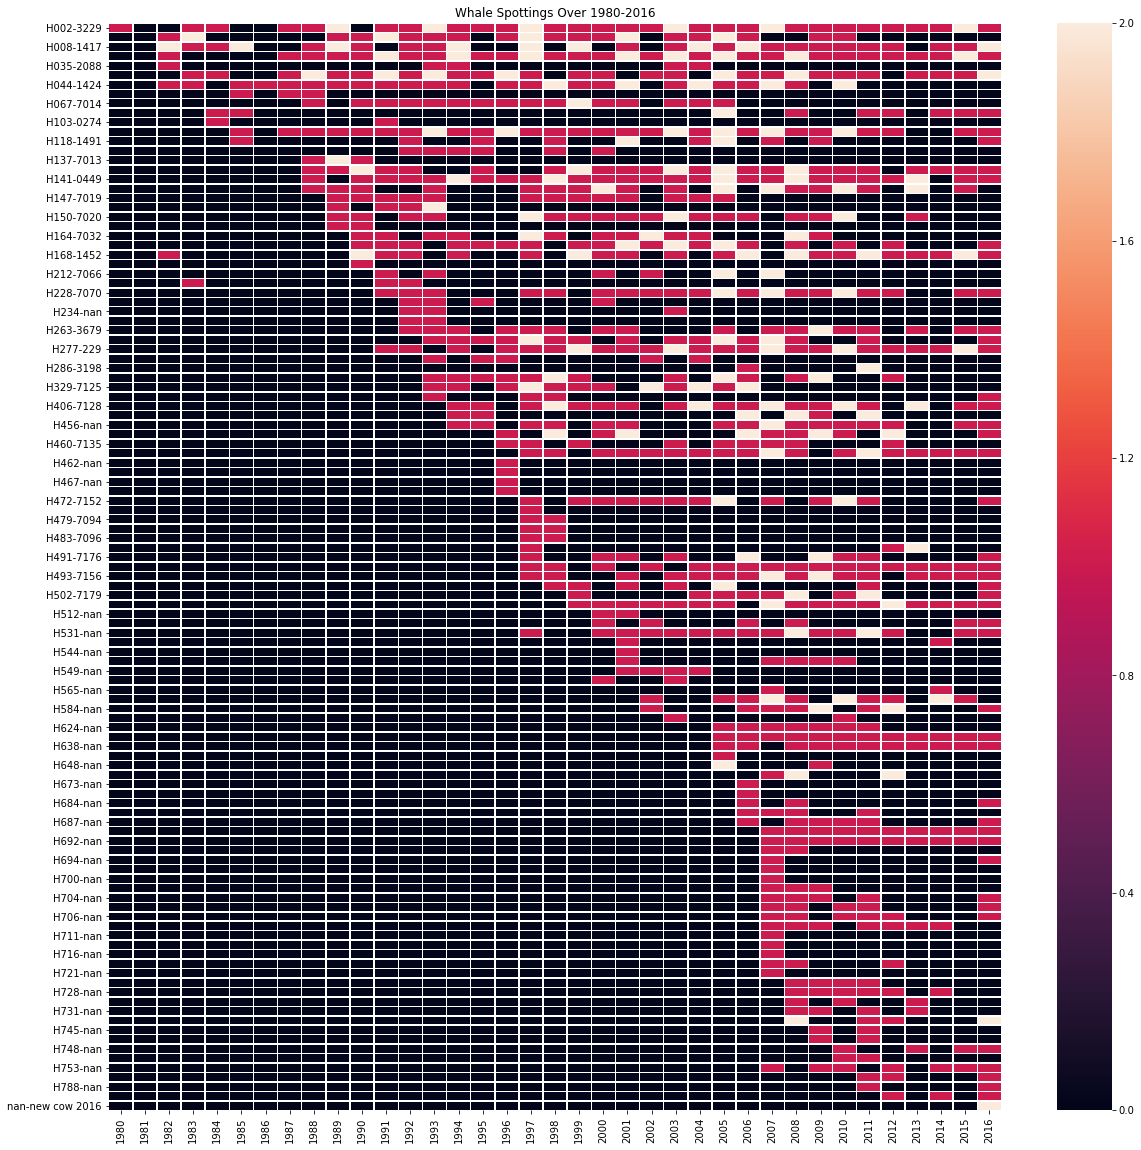

In [7]:
fig, ax = plt.subplots(1,1, figsize=(20,20))
ax.set_title('Whale Spottings Over 1980-2016')
sns.heatmap(cleaned_matrix, ax=ax, linewidths=0.5)

In [8]:
(cleaned_matrix['2005'] == 2).sum() / (cleaned_matrix['2005'] > 0).sum()

0.4146341463414634

## Modeling

$$
    \begin{equation}
        \begin{aligned}
        \text{age}_{i,t+1} &= \text{age}_{i,t} + 1 & \text{age increases by one every year} \\
        \text{alive}_{i,t+1} &=
        \begin{cases}
          1, & \text{if age}_{i,t+1} = 0 \\
          0, & \text{if alive}_{i,t} = 0 \\
          Bernoulli(s_t) & \text{if alive}_{i,t} = 1 \\
        \end{cases} \\
        s_t &\sim Beta(\alpha_{s_t}=1, \beta_{s_t}=1) & \text{survival parameter} \\
        \text{repro_active}_{i,t+1} &=
        \begin{cases}
          0, & \text{if alive}_{i, t+1}=0 \text{ or age}_{i,t+1} < 9 \\
          1 & \text{otherwise}
        \end{cases} \\
        \text{birth}_{i,t+1} &=
        \begin{cases}
          0, & \text{if birth}_{t,i} = 1 \text{ or } \text{repro_active}_{i,t+1} = 0 \\
          Bernoulli(b_t) & \text{otherwise}
        \end{cases} \\
        b_t &\sim Beta(\alpha_{b_t}=1, \beta_{b_t}=1) & \text{birth parameter} \\
        \text{count}_{i,t+1} &=
        \begin{cases}
            0, & \text{if alive}_{i,t+1} = 0 \\
            1 + \text{birth}_{i,t+1} & \text{if} Bernoulli(d_t) = 1
        \end{cases} \\
        d_t &\sim Beta(\alpha_{d_t}=1, \beta_{d_t}=1) & \text{detection parameter} \\
        \end{aligned}
    \end{equation}
$$

#### Constants

In [9]:
REPRO_AGE = 9
MAX_AVG_AGE = 80
STUDY_START_YEAR_MINUS_1 = 2004
STUDY_END_YEAR = 2016
STUDY_YEAR_COLUMNS_PLUS_LEFT_PADDING = list(map(lambda x: str(x), np.arange(STUDY_START_YEAR_MINUS_1, STUDY_END_YEAR + 1)))
STUDY_YEAR_COLUMNS = STUDY_YEAR_COLUMNS_PLUS_LEFT_PADDING[1:]
MAX_NUM_POPULATIONS = len(STUDY_YEAR_COLUMNS) * cleaned_matrix.shape[0]

In [10]:
def age_next_year(age_current_year):
    return age_current_year + 1

def alive_next_year(age_next_year, alive_current_year, survival_proba_next_year):
    if age_next_year == 0:
        return 1
    if alive_current_year == 1:
        return 0
    
    return np.random.binomial(n=1, p=survival_proba_next_year)

def repro_active_next_year(alive_next_year, age_next_year):
    if alive_next_year == 0 or age_next_year < REPRO_AGE:
        return 0
    else:
        return 1
    
def birth_next_year(birth_current_year, repro_active_next_year, birth_proba_next_year):
    if birth_current_year == 1:
        return 0
    if repro_active_next_year == 0:
        return 0
    return np.random.binomial(n=1, p=birth_proba_next_year)

def count_next_year(alive_next_year, detection_proba_next_year):
    if alive_next_year == 0:
        return 0
    
    return np.random.binomial(n=1, p=detection_proba_next_year)
    

### Generate Priors

In [11]:
STUDY_YEAR_COLUMNS_PLUS_LEFT_PADDING

['2004',
 '2005',
 '2006',
 '2007',
 '2008',
 '2009',
 '2010',
 '2011',
 '2012',
 '2013',
 '2014',
 '2015',
 '2016']

### test model


$$
    \begin{equation}
        \begin{aligned}
        \text{age}_{i,t} &= Uniform(10, 15) & \text{in years} \\
        \text{alive}_{i,t} &=
            \begin{cases}       
              0, & \text{if age}_{i,t} < 0 \\
              Bernoulli(s_t) & \text{otherwise} \\
            \end{cases} \\
        s_t &\sim Beta(\alpha_{s_t}=1, \beta_{s_t}=1) & \text{survival parameter} \\
        \text{repro_active}_{i,t} &=
            \begin{cases}
              0, & \text{if alive}_{i, t}=0 \text{ or age}_{i,t} < 9 \\
              1 & \text{otherwise}
            \end{cases} \\
        \text{birth}_{i,t} &=
            \begin{cases}
              0, & \text{repro_active}_{i,t} = 0 \\
              Bernoulli(b_t) & \text{otherwise}
            \end{cases} \\ 
        b_t &\sim Beta(\alpha_{b_t}=1, \beta_{b_t}=1) & \text{birth parameter} \\
        \text{count}_{i,t} &=
            \begin{cases}
                0, & \text{if alive}_{i,t} = 0 \text{ or } Bernoulli(d_t) = 0 \\
                1 + \text{birth}_{i,t} & \text{if alive}_{i,t} = 1 \text{ and } Bernoulli(d_t) = 1
            \end{cases} \\
        d_t &\sim Beta(\alpha_{d_t}=1, \beta_{d_t}=1) & \text{detection parameter} \\
        \end{aligned}
    \end{equation}
$$

In [12]:
cleaned_matrix.index

Index(['H002-3229', 'H004-1422', 'H008-1417', 'H009-1419', 'H035-2088',
       'H042-1451', 'H044-1424', 'H065-7002', 'H067-7014', 'H102-nan',
       ...
       'H738-nan', 'H745-nan', 'H747-nan', 'H748-nan', 'H752-nan', 'H753-nan',
       'H782-nan', 'H788-nan', 'H798-nan', 'nan-new cow 2016'],
      dtype='object', length=115)

In [13]:
min_age_prior(cleaned_matrix.loc['H002-3229'], 2005)

25

### known_birth_years

In [14]:
known_birth_years = {
    'H009-1419': 1982,
    'H065-7002': 1985,
    'H067-7014': 1988,
    'H169-7029': 1990,
    'H456-nan': 1994,
    'H464-nan': 1996,
    'H473-7092': 1997,
    'H479-7094': 1997,
    'H483-7096': 1997,
    'H549-nan': 2001,
    'H551-nan': 2000,
    'H565-nan': 2000,
    'H590-nan': 2003,
    'H624-nan': 2005,
    'H626-nan': 2005,
    'H638-nan': 2005,
    'H647-nan': 2005,
}

In [15]:
min_age_prior(cleaned_matrix.loc['H647-nan'], 2004)

-1

### name

In [16]:
def name(quality, year, indiv=None):
    if indiv == None:
        return quality + '_' + str(year)
    else:
        return quality + '_' + str(year) + '_' + indiv 

In [17]:
min_age_prior(row=cleaned_matrix.loc['H008-1417'], year=1982)

9

In [18]:
min_age_prior(row=cleaned_matrix.loc['H002-3229'], year=1980)

0

In [19]:
min_age_prior(row=cleaned_matrix.loc['H002-3229'], year=1981)

1

In [20]:
min_age_prior(row=cleaned_matrix.loc['H462-nan'], year=1996)

0

In [21]:
np.where(cleaned_matrix.loc['H008-1417'] == 2)[0].min()

2

In [22]:
len(np.where(cleaned_matrix.loc['H008-1417'] == 3)[0])

0

In [23]:
cleaned_matrix.loc['H008-1417'].index[2]

'1982'

### age

In [24]:
def age(year, indiv, known_birth_years_dict, data):
    min_age = min_age_prior(
        row=data.loc[indiv],
        year=int(year)
    )
    
    if indiv in known_birth_years_dict:      
        return pm.Uniform(
            name('age', year, indiv=indiv),
            lower=min_age,
            upper=min_age + 1 
        )
    else:
        return pm.Uniform(
            name('age', year, indiv=indiv),
            lower=min_age,
            upper=80
        )        

### years_prior_to

In [123]:
def years_prior_to(year, year_columns):
    return list(
        map(
            lambda x: str(x), np.arange(int(year_columns.min()), int(year))
        )
    )

### years_subsequent_to

In [26]:
def years_subsequent_to(year, year_columns):
    return list(
        map(
            lambda x: str(x), np.arange(int(year + 1), int(year_columns.max()))
        )
    )

### alive

TODO: try using some modified sigmoid function that takes in age and returns a value that is 1 or 0

In [27]:
def logistic(x):
    return 1.0 / (1.0 + np.exp(-x))

In [28]:
logistic(2)

0.8807970779778823

In [29]:
def alive(year, indiv, data, age, age_greater_than_0_beta, alive_alpha):
    """
        aliveness probability
        
        age < 0 or were already dead before
    """
    
    age_greater_than_9 = pm.math.sigmoid(age)
    alive_proba = pm.math.sigmoid(age_greater_than_9 * age_greater_than_0_beta + alive_alpha)

    if data.loc[indiv, str(year)] > 0:
        return pm.Bernoulli(
            name('alive', year, indiv=indiv), 
            p=alive_proba,
            observed=1
        )
    elif (data.loc[indiv, years_prior_to(year, data.columns)].sum() > 0) and \
        (data.loc[indiv, years_subsequent_to(year, data.columns)].sum() > 0):
        return pm.Bernoulli(
            name('alive', year, indiv=indiv), 
            p=alive_proba,
            observed=1
        )
    else:
        
        return pm.Bernoulli(
            name('alive', year, indiv=indiv),
            p=alive_proba
        )
        


### repro_active

In [30]:
def repro_active(alive, age):
    return pm.math.gt(age, 9) * alive

### birth

In [31]:
cleaned_matrix.loc['H009-1419']['2005']

2

TODO: just use a sigmoid that takes in repr_active_beta and birth_alpha so we won't need to do metropolis

In [32]:
def birth(year, indiv, repr_active, proba_birth_repr_active, proba_birth_not_repr_active, data):
    indiv_data = data.loc[indiv]
        
    proba_birth = pm.math.switch(
        pm.math.eq(repr_active, 1),
        proba_birth_repr_active,
        proba_birth_not_repr_active
    )
    
    if indiv_data.loc[str(year)] == 1 or indiv_data.loc[str(year+1)] == 2:
        return pm.Bernoulli(
            name('birth', year, indiv=indiv),
            p=proba_birth_repr_active,
            observed=0
        ) 
    
    elif indiv_data.loc[str(year-1)] == 2:
        return pm.Bernoulli(
            name('birth', year, indiv=indiv),
            p=proba_birth_repr_active,
            observed=0
        ) 
    
    elif indiv_data.loc[str(year)] == 2:
        return pm.Bernoulli(
            name('birth', year, indiv=indiv),
            p=proba_birth_repr_active,
            observed=1
        )
    else:
        return pm.Bernoulli(
            name('birth', year, indiv=indiv),
            p=proba_birth
        )

### detect

In [33]:
def detect(year, indiv, data, proba_detect):
    if data.loc[indiv, str(year)] > 0:
        return pm.Bernoulli(
            name('detect', year, indiv=indiv),
            p=proba_detect,
            observed=1
        )
    else:
        return pm.Bernoulli(
            name('detect', year, indiv=indiv),
            p=proba_detect,
            observed=0
        )

Try using Constant(0) as the probability when whale is not reproductively active

### individual model

In [34]:
cleaned_matrix.iloc[0][STUDY_YEAR_COLUMNS]

2005    1
2006    1
2007    2
2008    1
2009    1
2010    1
2011    1
2012    1
2013    1
2014    1
2015    2
2016    1
Name: H002-3229, dtype: int64

In [35]:
np.random.multinomial(n=2, pvals=[0.3, 0.2, 0.5], size=50).mean(axis=0)

array([0.64, 0.42, 0.94])

In [36]:
np.ones_like([1 , 2 ,3 ])

array([1, 1, 1])

In [37]:
obs = np.array([0, 1, 2])

In [38]:
for i, j in enumerate(cleaned_matrix.iloc[0][['2005', '2006']]):
    print(i, j)

0 1
1 1


In [39]:
STUDY_YEAR_COLUMNS

['2005',
 '2006',
 '2007',
 '2008',
 '2009',
 '2010',
 '2011',
 '2012',
 '2013',
 '2014',
 '2015',
 '2016']

In [40]:
cleaned_matrix.iloc[0]

1980    1
1981    0
1982    0
1983    1
1984    1
1985    0
1986    0
1987    1
1988    1
1989    2
1990    0
1991    1
1992    1
1993    2
1994    1
1995    1
1996    1
1997    2
1998    1
1999    1
2000    1
2001    1
2002    1
2003    2
2004    1
2005    1
2006    1
2007    2
2008    1
2009    1
2010    1
2011    1
2012    1
2013    1
2014    1
2015    2
2016    1
Name: H002-3229, dtype: int64

In [41]:
toy_dataset = cleaned_matrix.iloc[0][['2005', '2006', '2007', '2008']]
toy_dataset

2005    1
2006    1
2007    2
2008    1
Name: H002-3229, dtype: int64

In [42]:
toy_dataset = cleaned_matrix.iloc[0][['2007']]
toy_dataset

2007    2
Name: H002-3229, dtype: int64

In [43]:
with pm.Model() as recreate_issue_model:
    p = pm.Dirichlet('p', a=np.ones(3))
    pm.Categorical(
        'obs',
#         p=[False, False, True],
        p=p,
        observed=2
    )
    recreate_issue_trace = pm.sample()

WARNING (theano.gof.compilelock): Overriding existing lock by dead process '3302' (I am process '4690')
Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]
INFO:pymc3:NUTS: [p]
Sampling 4 chains: 100%|██████████| 4000/4000 [00:01<00:00, 3263.61draws/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9e89dcb1d0>,
      dtype=object)

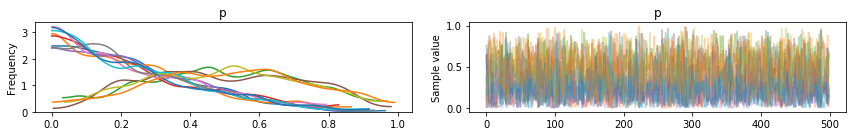

In [44]:
pm.traceplot(recreate_issue_trace)

In [45]:
toy_dataset.shape

(1,)

TODO:

- take into account age / reproductive_activeness
- use old posteriors as new priors for individual updating

In [157]:
def from_posterior(param, samples):
    """ See https://docs.pymc.io/notebooks/updating_priors.html """
    smin, smax = np.min(samples), np.max(samples)
    width = smax - smin
    x = np.linspace(smin, smax, 100)
    y = stats.gaussian_kde(samples)(x)

    # what was never sampled should have a small probability but not 0,
    # so we'll extend the domain and use linear approximation of density on it
    
    # maybe we'll need to make sure that x is bounded between 0 and 1
    
    min_explore_x = x[0] - 3 * width
    max_explore_x = x[-1] + 3 * width
    
#     x = np.concatenate([
#         [max(min_explore_x, 0.0001)],
#         x,
#         [min(max_explore_x, 0.9999)]
#     ])
    x = np.concatenate([[x[0] - 3 * width], x, [x[-1] + 3 * width]])

    y = np.concatenate([[0], y, [0]])
    
    return pm.distributions.Interpolated(param, x, y)



In [48]:
# samples = np.random.beta(a=1, b=1, size=100000)
# x, y = from_posterior('abc', samples)
# pd.DataFrame({'x': x, 'y': y}).plot.scatter(x='x', y='y')

In [49]:
from IPython.core.debugger import set_trace

### process_individual

In [63]:
cleaned_matrix.index[0]

'H002-3229'

In [120]:
def first_sighting(year, indiv_id, indiv_data):
    indiv_years_prior_to = indiv_data[years_prior_to(int(year), indiv_data.index)]
    prior_sightings = np.where(indiv_years_prior_to >= 1)[0]
    
    if prior_sightings.any():
        return int(indiv_years_prior_to.index[prior_sightings[0]])
    else:
        return None


In [179]:
def process_individual(p, indiv_data, study_year_columns, indiv_id):
    """
        p: dict.
            Stores parameters.
    """

    study_data = indiv_data[study_year_columns]
    
    indices = study_data.index
    
    p['zero'] = pm.Constant('zero', c=0)
    p['one'] = pm.Constant('one', c=1)
    
    for i, obs in enumerate(study_data):
        last_year = indices[i-1]
        year = indices[i]

        # generate alive
        if i == 0:
            proba_alive = p['proba_alive_' + str(year)]
        else:
            proba_alive = pm.math.switch(
                pm.math.eq(p['alive_' + str(last_year)], 1),
                p['proba_alive_' + str(year)],
                p['zero']
            )

        alive_args = {
            'name': 'alive_' + str(year),
            'p': proba_alive,
        }
        
#         if obs > 0 or \
#             (
#                 (indiv_data[years_prior_to(int(year), indiv_data.index)].sum() > 0) and \
#                 (indiv_data[years_subsequent_to(int(year), indiv_data.index)].sum() > 0)
#             ):
                
#             alive_args['observed'] = 1

        p['alive_' + str(year)] = pm.Bernoulli(**alive_args)
        
        # generate repro_active
        
        proba_repro_name = 'proba_repro_active_' + str(year)
        
        proba_repro_active_args = {
            'name': proba_repro_name,
            'alpha': 1.0,
            'beta': 1.0

        }
        
        # if whale gave birth in the past, then whale must be repro_active
        # if we observe that the earliest observed sighting was more than 9 years ago,
        # then whale is repro_active
        
        first_sighting_indiv = first_sighting(int(year), indiv_id, indiv_data)
        
#         if (indiv_data[years_prior_to(int(year), indiv_data.index)] == 2).sum() > 0:
#             proba_repro_active_args['observed'] = 1
#         elif first_sighting_indiv != None and int(year) - first_sighting_indiv > 9:
#             proba_repro_active_args['observed'] = 1
            
        
        # set the probability of being repr_active

#         p['proba_repro_active_' + str(year)] = pm.math.switch(
#         )
#                 p['repro_active_' + str(last_year)] * p['alive_' + str(year)] * 1.0
#         p[proba_repro_active_args['name']] = pm.Beta('')

        # so there's a beta and an alpha. Each year the beta and alpha would be different?

        repr_active_args = {
            'name': 'repro_active_' + str(year),
            'p': pm.Beta(**proba_repro_active_args),
        }
        
        p['repro_active_' + str(year)] = pm.Bernoulli(**repr_active_args)
        
        # generate detect

        p['detect_' + str(year)] = pm.Bernoulli(
            'detect_' + str(year),
            p=p['proba_detection_'  +str(year)],
#             observed=int(obs>0)
        )

        # generate birth

        birth_args = {
            'name': 'birth_' + str(year),
            'p': pm.math.switch(
                p['repro_active_' + str(year)] * p['alive_' + str(year)],
                p['proba_birth_' + str(year)],
                p['zero']
            )
        }

#         if obs == 2:
#             birth_args['observed'] = 1
#         elif obs == 1 or indiv_data[last_year] == 2:
#             birth_args['observed'] = 0

        p['birth_' + str(indices[i])] = pm.Bernoulli(**birth_args)

        # observations

        obs_0 = pm.math.or_(pm.math.eq(p['alive_' + str(year)], 0), pm.math.eq(p['detect_' + str(year)], 0))
        obs_1 = p['alive_' + str(year)] * p['detect_' + str(year)] * pm.math.eq(p['birth_' + str(year)], 0)
        obs_2 = 1 - obs_0 - obs_1

        pm.Categorical(
            'observed_counts_' + str(year),
            # p=obs_proba,
            p=tt.stack(
                [
                    pm.math.sigmoid(obs_0 * 1000 - 500),
                    pm.math.sigmoid(obs_1 * 1000 - 500),
                    pm.math.sigmoid(obs_2 * 1000 - 500)
                ],
                axis=0
            ),
            observed=obs
        )


In [151]:
def save_model(model, trace, index, indiv_id):
    with open('data/model_' + str(index) + '_' + indiv_id + '.pkl', 'wb') as buff:
        pickle.dump({'model': indiv_model, 'trace': trace}, buff)

In [180]:
index = 0
indiv_dataset = cleaned_matrix.iloc[index]
indiv_id = cleaned_matrix.index[index]

with pm.Model() as indiv_model:
    p = {}

    for i in STUDY_YEAR_COLUMNS:
        p['proba_birth_' + str(i)] = pm.Beta('proba_birth_' + str(i), alpha=1.0, beta=1.0)
        p['proba_detection_' + str(i)] = pm.Beta('proba_detection_' + str(i), alpha=1.0, beta=1.0)
        p['proba_alive_' + str(i)] = pm.Beta('proba_alive_' + str(i), alpha=1.0, beta=1.0)


    process_individual(p, indiv_dataset, STUDY_YEAR_COLUMNS, indiv_id)

    trace = pm.sample()

save_model(
    model=indiv_model,
    trace=trace,
    index=index,
    indiv_id=indiv_id,
)


Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
INFO:pymc3:CompoundStep
>NUTS: [proba_repro_active_2016, proba_repro_active_2015, proba_repro_active_2014, proba_repro_active_2013, proba_repro_active_2012, proba_repro_active_2011, proba_repro_active_2010, proba_repro_active_2009, proba_repro_active_2008, proba_repro_active_2007, proba_repro_active_2006, proba_repro_active_2005, proba_alive_2016, proba_detection_2016, proba_birth_2016, proba_alive_2015, proba_detection_2015, proba_birth_2015, proba_alive_2014, proba_detection_2014, proba_birth_2014, proba_alive_2013, proba_detection_2013, proba_birth_2013, proba_alive_2012, proba_detection_2012, proba_birth_2012, proba_alive_2011, proba_detection_2011, proba_birth_2011, proba_alive_2010, proba_detection_2010, proba_birth_2010, proba_alive_2009, proba_detection_2009, proba_birth_2009, proba_alive_2008, proba_detection_2008, proba_birth_2008, proba_alive_2007, proba_detection_20

ParallelSamplingError: Bad initial energy

GridSpec(1, 2, width_ratios=[3, 1])

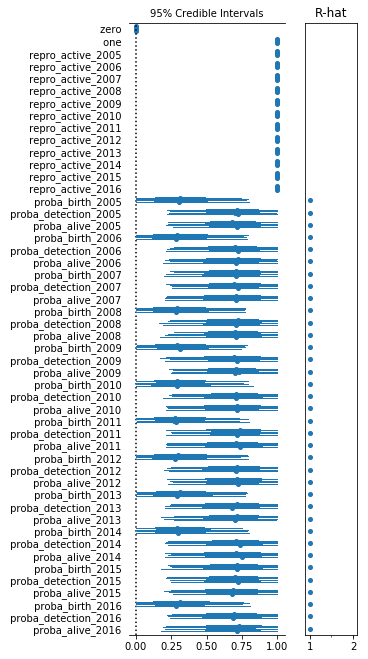

In [171]:
plt.figure(figsize=(5,10))
pm.forestplot(trace)

In [172]:
traces = [trace]

In [178]:
cleaned_matrix.iloc[1]

1980    0
1981    0
1982    1
1983    2
1984    0
1985    0
1986    0
1987    0
1988    0
1989    1
1990    1
1991    2
1992    1
1993    1
1994    1
1995    0
1996    1
1997    2
1998    1
1999    1
2000    1
2001    2
2002    0
2003    1
2004    1
2005    2
2006    1
2007    0
2008    0
2009    1
2010    1
2011    0
2012    0
2013    0
2014    0
2015    0
2016    0
Name: H004-1422, dtype: int64

In [177]:
for indiv_id, indiv_dataset in cleaned_matrix.iloc[1:][STUDY_YEAR_COLUMNS].iterrows():
    index = np.where(cleaned_matrix.index == indiv_id)[0][0]
    
    model = pm.Model()
    with model:
        p = {}
        
        for i in STUDY_YEAR_COLUMNS:
            p['proba_birth_' + str(i)] = from_posterior('proba_birth_' + str(i), trace['proba_birth_' + str(i)])
            p['proba_detection_' + str(i)] = from_posterior('proba_detection_' + str(i), trace['proba_detection_' + str(i)])
            p['proba_alive_' + str(i)] = from_posterior('proba_alive_' + str(i), trace['proba_alive_' + str(i)])
            
            
        process_individual(p, indiv_dataset, STUDY_YEAR_COLUMNS, indiv_id)
        
        trace = pm.sample()
        traces.append(trace)
        
    save_model(model, trace, index, indiv_id)

Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
INFO:pymc3:CompoundStep
>NUTS: [proba_repro_active_2005, proba_alive_2016, proba_detection_2016, proba_birth_2016, proba_alive_2015, proba_detection_2015, proba_birth_2015, proba_alive_2014, proba_detection_2014, proba_birth_2014, proba_alive_2013, proba_detection_2013, proba_birth_2013, proba_alive_2012, proba_detection_2012, proba_birth_2012, proba_alive_2011, proba_detection_2011, proba_birth_2011, proba_alive_2010, proba_detection_2010, proba_birth_2010, proba_alive_2009, proba_detection_2009, proba_birth_2009, proba_alive_2008, proba_detection_2008, proba_birth_2008, proba_alive_2007, proba_detection_2007, proba_birth_2007, proba_alive_2006, proba_detection_2006, proba_birth_2006, proba_alive_2005, proba_detection_2005, proba_birth_2005]
INFO:pymc3:>NUTS: [proba_repro_active_2005, proba_alive_2016, proba_detection_2016, proba_birth_2016, proba_alive_2015, proba_detection_2

ParallelSamplingError: Bad initial energy

INFO (theano.gof.compilelock): Waiting for existing lock by process '30190' (I am process '30188')
INFO:theano.gof.compilelock:Waiting for existing lock by process '30190' (I am process '30188')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/edderic/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir
INFO:theano.gof.compilelock:To manually release the lock, delete /home/edderic/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir
/home/edderic/miniconda3/envs/mics-whales/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/edderic/miniconda3/envs/mics-whales/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


In [419]:
del traces[-1]

In [429]:
trace = traces[-1]

In [421]:
len(traces)

25

In [422]:
[0,1,2,3,4][2:]

[2, 3, 4]

In [427]:
STUDY_YEAR_COLUMNS

['2005',
 '2006',
 '2007',
 '2008',
 '2009',
 '2010',
 '2011',
 '2012',
 '2013',
 '2014',
 '2015',
 '2016']

In [428]:
trace

[<MultiTrace: 4 chains, 500 iterations, 73 variables>,
 <MultiTrace: 4 chains, 1000 iterations, 89 variables>,
 <MultiTrace: 4 chains, 1000 iterations, 75 variables>,
 <MultiTrace: 4 chains, 1000 iterations, 73 variables>,
 <MultiTrace: 4 chains, 1000 iterations, 97 variables>,
 <MultiTrace: 4 chains, 1000 iterations, 75 variables>,
 <MultiTrace: 4 chains, 1000 iterations, 87 variables>,
 <MultiTrace: 4 chains, 1000 iterations, 97 variables>,
 <MultiTrace: 4 chains, 1000 iterations, 95 variables>,
 <MultiTrace: 4 chains, 1000 iterations, 83 variables>,
 <MultiTrace: 4 chains, 1000 iterations, 97 variables>,
 <MultiTrace: 4 chains, 1000 iterations, 77 variables>,
 <MultiTrace: 4 chains, 1000 iterations, 89 variables>,
 <MultiTrace: 4 chains, 1000 iterations, 97 variables>,
 <MultiTrace: 4 chains, 1000 iterations, 97 variables>,
 <MultiTrace: 4 chains, 1000 iterations, 75 variables>,
 <MultiTrace: 4 chains, 1000 iterations, 75 variables>,
 <MultiTrace: 4 chains, 1000 iterations, 81 varia

In [430]:
for i, indiv_dataset in cleaned_matrix.iloc[25:][STUDY_YEAR_COLUMNS].iterrows():
    model = pm.Model()
    print("\n " + str(i) + "\n" )
    with model:
        p = {}
        
        for y in STUDY_YEAR_COLUMNS:
            p['proba_birth_' + str(y)] = from_posterior('proba_birth_' + str(y), trace['proba_birth_' + str(y)])
            p['proba_detection_' + str(y)] = from_posterior('proba_detection_' + str(y), trace['proba_detection_' + str(y)])
            p['proba_alive_' + str(y)] = from_posterior('proba_alive_' + str(y), trace['proba_alive_' + str(y)])
            
            
        process_individual(p, indiv_dataset)
        
        trace = pm.sample(1000)
        traces.append(trace)
        
        
        


 H169-7029



Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
INFO:pymc3:CompoundStep
>NUTS: [proba_alive_2016, proba_detection_2016, proba_birth_2016, proba_alive_2015, proba_detection_2015, proba_birth_2015, proba_alive_2014, proba_detection_2014, proba_birth_2014, proba_alive_2013, proba_detection_2013, proba_birth_2013, proba_alive_2012, proba_detection_2012, proba_birth_2012, proba_alive_2011, proba_detection_2011, proba_birth_2011, proba_alive_2010, proba_detection_2010, proba_birth_2010, proba_alive_2009, proba_detection_2009, proba_birth_2009, proba_alive_2008, proba_detection_2008, proba_birth_2008, proba_alive_2007, proba_detection_2007, proba_birth_2007, proba_alive_2006, proba_detection_2006, proba_birth_2006, proba_alive_2005, proba_detection_2005, proba_birth_2005]
INFO:pymc3:>NUTS: [proba_alive_2016, proba_detection_2016, proba_birth_2016, proba_alive_2015, proba_detection_2015, proba_birth_2015, proba_alive_2014, proba_det


 H212-7066



INFO (theano.gof.compilelock): Refreshing lock /home/edderic/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir/lock
INFO:theano.gof.compilelock:Refreshing lock /home/edderic/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/edderic/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir/lock
INFO:theano.gof.compilelock:Refreshing lock /home/edderic/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/edderic/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir/lock
INFO:theano.gof.compilelock:Refreshing lock /home/edderic/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /h


 H216-7068



INFO (theano.gof.compilelock): Refreshing lock /home/edderic/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir/lock
INFO:theano.gof.compilelock:Refreshing lock /home/edderic/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/edderic/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir/lock
INFO:theano.gof.compilelock:Refreshing lock /home/edderic/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/edderic/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir/lock
INFO:theano.gof.compilelock:Refreshing lock /home/edderic/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /h


 H228-7070



INFO (theano.gof.compilelock): Refreshing lock /home/edderic/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir/lock
INFO:theano.gof.compilelock:Refreshing lock /home/edderic/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/edderic/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir/lock
INFO:theano.gof.compilelock:Refreshing lock /home/edderic/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/edderic/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir/lock
INFO:theano.gof.compilelock:Refreshing lock /home/edderic/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /h


 H231-7116



INFO (theano.gof.compilelock): Refreshing lock /home/edderic/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir/lock
INFO:theano.gof.compilelock:Refreshing lock /home/edderic/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/edderic/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir/lock
INFO:theano.gof.compilelock:Refreshing lock /home/edderic/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/edderic/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir/lock
INFO:theano.gof.compilelock:Refreshing lock /home/edderic/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /h


 H234-nan



INFO (theano.gof.compilelock): Refreshing lock /home/edderic/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir/lock
INFO:theano.gof.compilelock:Refreshing lock /home/edderic/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/edderic/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir/lock
INFO:theano.gof.compilelock:Refreshing lock /home/edderic/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/edderic/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir/lock
INFO:theano.gof.compilelock:Refreshing lock /home/edderic/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /h


 H246-7161



INFO (theano.gof.compilelock): Refreshing lock /home/edderic/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir/lock
INFO:theano.gof.compilelock:Refreshing lock /home/edderic/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/edderic/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir/lock
INFO:theano.gof.compilelock:Refreshing lock /home/edderic/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/edderic/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir/lock
INFO:theano.gof.compilelock:Refreshing lock /home/edderic/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /h


 H263-3679



INFO (theano.gof.compilelock): Refreshing lock /home/edderic/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir/lock
INFO:theano.gof.compilelock:Refreshing lock /home/edderic/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/edderic/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir/lock
INFO:theano.gof.compilelock:Refreshing lock /home/edderic/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/edderic/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir/lock
INFO:theano.gof.compilelock:Refreshing lock /home/edderic/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /h


 H275-7113



INFO (theano.gof.compilelock): Refreshing lock /home/edderic/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir/lock
INFO:theano.gof.compilelock:Refreshing lock /home/edderic/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/edderic/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir/lock
INFO:theano.gof.compilelock:Refreshing lock /home/edderic/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/edderic/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir/lock
INFO:theano.gof.compilelock:Refreshing lock /home/edderic/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /h


 H277-229



INFO (theano.gof.compilelock): Refreshing lock /home/edderic/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir/lock
INFO:theano.gof.compilelock:Refreshing lock /home/edderic/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/edderic/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir/lock
INFO:theano.gof.compilelock:Refreshing lock /home/edderic/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/edderic/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir/lock
INFO:theano.gof.compilelock:Refreshing lock /home/edderic/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /h


 H285-7118



INFO (theano.gof.compilelock): Refreshing lock /home/edderic/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir/lock
INFO:theano.gof.compilelock:Refreshing lock /home/edderic/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/edderic/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir/lock
INFO:theano.gof.compilelock:Refreshing lock /home/edderic/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/edderic/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir/lock
INFO:theano.gof.compilelock:Refreshing lock /home/edderic/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /h


 H286-3198



INFO (theano.gof.compilelock): Refreshing lock /home/edderic/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir/lock
INFO:theano.gof.compilelock:Refreshing lock /home/edderic/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/edderic/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir/lock
INFO:theano.gof.compilelock:Refreshing lock /home/edderic/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/edderic/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir/lock
INFO:theano.gof.compilelock:Refreshing lock /home/edderic/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /h


 H288-7115



INFO (theano.gof.compilelock): Refreshing lock /home/edderic/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir/lock
INFO:theano.gof.compilelock:Refreshing lock /home/edderic/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/edderic/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir/lock
INFO:theano.gof.compilelock:Refreshing lock /home/edderic/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/edderic/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir/lock
INFO:theano.gof.compilelock:Refreshing lock /home/edderic/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /h


 H329-7125



INFO (theano.gof.compilelock): Refreshing lock /home/edderic/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir/lock
INFO:theano.gof.compilelock:Refreshing lock /home/edderic/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/edderic/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir/lock
INFO:theano.gof.compilelock:Refreshing lock /home/edderic/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/edderic/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir/lock
INFO:theano.gof.compilelock:Refreshing lock /home/edderic/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /h


 H353-3705



INFO (theano.gof.compilelock): Refreshing lock /home/edderic/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir/lock
INFO:theano.gof.compilelock:Refreshing lock /home/edderic/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/edderic/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir/lock
INFO:theano.gof.compilelock:Refreshing lock /home/edderic/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/edderic/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir/lock
INFO:theano.gof.compilelock:Refreshing lock /home/edderic/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /h


 H406-7128



INFO (theano.gof.compilelock): Refreshing lock /home/edderic/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir/lock
INFO:theano.gof.compilelock:Refreshing lock /home/edderic/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/edderic/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir/lock
INFO:theano.gof.compilelock:Refreshing lock /home/edderic/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/edderic/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir/lock
INFO:theano.gof.compilelock:Refreshing lock /home/edderic/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /h


 H437-7164



INFO (theano.gof.compilelock): Refreshing lock /home/edderic/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir/lock
INFO:theano.gof.compilelock:Refreshing lock /home/edderic/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/edderic/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir/lock
INFO:theano.gof.compilelock:Refreshing lock /home/edderic/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/edderic/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir/lock
INFO:theano.gof.compilelock:Refreshing lock /home/edderic/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /h


 H456-nan



INFO (theano.gof.compilelock): Refreshing lock /home/edderic/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir/lock
INFO:theano.gof.compilelock:Refreshing lock /home/edderic/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/edderic/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir/lock
INFO:theano.gof.compilelock:Refreshing lock /home/edderic/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/edderic/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir/lock
INFO:theano.gof.compilelock:Refreshing lock /home/edderic/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /h


 H458-7150



INFO (theano.gof.compilelock): Refreshing lock /home/edderic/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir/lock
INFO:theano.gof.compilelock:Refreshing lock /home/edderic/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/edderic/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir/lock
INFO:theano.gof.compilelock:Refreshing lock /home/edderic/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/edderic/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir/lock
INFO:theano.gof.compilelock:Refreshing lock /home/edderic/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /h


 H460-7135



INFO (theano.gof.compilelock): Refreshing lock /home/edderic/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir/lock
INFO:theano.gof.compilelock:Refreshing lock /home/edderic/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/edderic/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir/lock
INFO:theano.gof.compilelock:Refreshing lock /home/edderic/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/edderic/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir/lock
INFO:theano.gof.compilelock:Refreshing lock /home/edderic/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /h


 H461-7151



INFO (theano.gof.compilelock): Refreshing lock /home/edderic/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir/lock
INFO:theano.gof.compilelock:Refreshing lock /home/edderic/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/edderic/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir/lock
INFO:theano.gof.compilelock:Refreshing lock /home/edderic/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/edderic/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir/lock
INFO:theano.gof.compilelock:Refreshing lock /home/edderic/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /h


 H462-nan



INFO (theano.gof.compilelock): Refreshing lock /home/edderic/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir/lock
INFO:theano.gof.compilelock:Refreshing lock /home/edderic/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/edderic/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir/lock
INFO:theano.gof.compilelock:Refreshing lock /home/edderic/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/edderic/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir/lock
INFO:theano.gof.compilelock:Refreshing lock /home/edderic/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /h


 H464-nan



INFO (theano.gof.compilelock): Refreshing lock /home/edderic/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir/lock
INFO:theano.gof.compilelock:Refreshing lock /home/edderic/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/edderic/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir/lock
INFO:theano.gof.compilelock:Refreshing lock /home/edderic/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/edderic/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir/lock
INFO:theano.gof.compilelock:Refreshing lock /home/edderic/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /h


 H467-nan



INFO (theano.gof.compilelock): Refreshing lock /home/edderic/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir/lock
INFO:theano.gof.compilelock:Refreshing lock /home/edderic/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/edderic/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir/lock
INFO:theano.gof.compilelock:Refreshing lock /home/edderic/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/edderic/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir/lock
INFO:theano.gof.compilelock:Refreshing lock /home/edderic/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /h


 H470-nan



INFO (theano.gof.compilelock): Refreshing lock /home/edderic/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir/lock
INFO:theano.gof.compilelock:Refreshing lock /home/edderic/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/edderic/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir/lock
INFO:theano.gof.compilelock:Refreshing lock /home/edderic/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/edderic/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir/lock
INFO:theano.gof.compilelock:Refreshing lock /home/edderic/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /h


 H472-7152



INFO (theano.gof.compilelock): Refreshing lock /home/edderic/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir/lock
INFO:theano.gof.compilelock:Refreshing lock /home/edderic/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/edderic/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir/lock
INFO:theano.gof.compilelock:Refreshing lock /home/edderic/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/edderic/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir/lock
INFO:theano.gof.compilelock:Refreshing lock /home/edderic/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /h


 H473-7092



INFO (theano.gof.compilelock): Refreshing lock /home/edderic/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir/lock
INFO:theano.gof.compilelock:Refreshing lock /home/edderic/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/edderic/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir/lock
INFO:theano.gof.compilelock:Refreshing lock /home/edderic/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/edderic/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir/lock
INFO:theano.gof.compilelock:Refreshing lock /home/edderic/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /h


 H479-7094



INFO (theano.gof.compilelock): Refreshing lock /home/edderic/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir/lock
INFO:theano.gof.compilelock:Refreshing lock /home/edderic/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/edderic/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir/lock
INFO:theano.gof.compilelock:Refreshing lock /home/edderic/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/edderic/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir/lock
INFO:theano.gof.compilelock:Refreshing lock /home/edderic/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /h


 H482-0496



INFO (theano.gof.compilelock): Refreshing lock /home/edderic/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir/lock
INFO:theano.gof.compilelock:Refreshing lock /home/edderic/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/edderic/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir/lock
INFO:theano.gof.compilelock:Refreshing lock /home/edderic/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/edderic/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir/lock
INFO:theano.gof.compilelock:Refreshing lock /home/edderic/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /h


 H483-7096



INFO (theano.gof.compilelock): Refreshing lock /home/edderic/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir/lock
INFO:theano.gof.compilelock:Refreshing lock /home/edderic/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/edderic/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir/lock
INFO:theano.gof.compilelock:Refreshing lock /home/edderic/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/edderic/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir/lock
INFO:theano.gof.compilelock:Refreshing lock /home/edderic/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /h

OSError: [Errno 12] Cannot allocate memory

In [431]:
len(traces)

54

In [436]:
np.where(cleaned_matrix.index == 'H483-7096')

(array([54]),)

In [437]:
import pickle

In [ ]:
with open('data/traces_54.pkl')
    pickle.dump()

In [406]:
traces[0]

<MultiTrace: 4 chains, 500 iterations, 73 variables>

In [407]:
traces[1]

<MultiTrace: 4 chains, 1000 iterations, 89 variables>

In [408]:
traces[2]

<MultiTrace: 4 chains, 1000 iterations, 75 variables>

In [409]:
traces[3]

<MultiTrace: 4 chains, 1000 iterations, 73 variables>

In [415]:
vars_of_interest = np.concatenate([
    ['proba_alive_' + str(y) for y in STUDY_YEAR_COLUMNS],
    ['proba_birth_' + str(y) for y in STUDY_YEAR_COLUMNS],
    ['proba_detection_' + str(y) for y in STUDY_YEAR_COLUMNS],
])

In [416]:
pm.summary(traces[25], varnames=vars_of_interest)

mean        sd  mc_error   hpd_2.5  hpd_97.5  \
proba_alive_2005      0.889938  0.067285  0.001246  0.753634  0.991224   
proba_alive_2006      0.886054  0.066306  0.001040  0.754860  0.993201   
proba_alive_2007      0.889504  0.065872  0.000963  0.759678  0.993386   
proba_alive_2008      0.888411  0.067726  0.001001  0.751009  0.992033   
proba_alive_2009      0.885776  0.060550  0.000936  0.770868  0.986953   
proba_alive_2010      0.879742  0.072505  0.001106  0.747397  0.993150   
proba_alive_2011      0.870969  0.076545  0.001187  0.716704  0.991846   
proba_alive_2012      0.867920  0.075783  0.001084  0.726582  0.989289   
proba_alive_2013      0.867550  0.081657  0.001056  0.704566  0.994396   
proba_alive_2014      0.859079  0.088307  0.001249  0.687015  0.987173   
proba_alive_2015      0.855103  0.089503  0.001308  0.675248  0.990385   
proba_alive_2016      0.841532  0.089181  0.001235  0.676654  0.990120   
proba_birth_2005      0.564974  0.128276  0.001904  0.292109  0.787898   
proba_birth_2006      0.241499  0.115075  0.001772  0.037504  0.476226   
proba_birth_2007      0.440148  0.144664  0.002146  0.188931  0.730041   
proba_birth_2008      0.448932  0.117439  0.001666  0.246737  0.718296   
proba_birth_2009      0.134409  0.079161  0.001263  0.007597  0.280863   
proba_birth_2010      0.348407  0.125599  0.001858  0.104331  0.585231   
proba_birth_2011      0.207548  0.092452  0.001277  0.032854  0.389781   
proba_birth_2012      0.183171  0.103130  0.001769  0.013783  0.376797   
proba_birth_2013      0.327777  0.128251  0.001550  0.093219  0.569013   
proba_birth_2014      0.184787  0.099559  0.001421  0.016533  0.376935   
proba_birth_2015      0.380044  0.137237  0.001834  0.128245  0.641927   
proba_birth_2016      0.268241  0.120874  0.001784  0.073323  0.494157   
proba_detection_2005  0.617579  0.099803  0.001507  0.424092  0.810680   
proba_detection_2006  0.448842  0.098973  0.001256  0.252327  0.626726   
proba_detection_2007  0.392744  0.080242  0.001127  0.246250  0.538258   
proba_detection_2008  0.538920  0.110408  0.001375  0.332440  0.750540   
proba_detection_2009  0.502447  0.097861  0.001182  0.312984  0.679666   
proba_detection_2010  0.474481  0.105737  0.001535  0.256272  0.673853   
proba_detection_2011  0.367250  0.105167  0.001528  0.175934  0.567350   
proba_detection_2012  0.333012  0.087482  0.001133  0.176683  0.501513   
proba_detection_2013  0.326070  0.088723  0.001103  0.160150  0.493191   
proba_detection_2014  0.315832  0.080277  0.001036  0.178475  0.470318   
proba_detection_2015  0.373328  0.100208  0.001262  0.191510  0.562783   
proba_detection_2016  0.432607  0.098451  0.001208  0.247463  0.611054   

                            n_eff      Rhat  
proba_alive_2005      3214.340861  1.000025  
proba_alive_2006      5063.493292  1.000131  
proba_alive_2007      4286.789618  1.000011  
proba_alive_2008      4804.938013  1.000175  
proba_alive_2009      4115.119501  0.999931  
proba_alive_2010      4465.525234  0.999561  
proba_alive_2011      4312.502861  1.000270  
proba_alive_2012      4555.018265  0.999713  
proba_alive_2013      5922.877106  0.999787  
proba_alive_2014      4621.550602  0.999927  
proba_alive_2015      5142.966067  0.999522  
proba_alive_2016      4165.567857  0.999952  
proba_birth_2005      4275.975346  0.999562  
proba_birth_2006      4027.818414  1.001129  
proba_birth_2007      5094.402379  0.999885  
proba_birth_2008      4470.495338  0.999775  
proba_birth_2009      3859.887065  0.999813  
proba_birth_2010      5034.191991  0.999771  
proba_birth_2011      4355.525967  1.000116  
proba_birth_2012      3675.876429  1.000579  
proba_birth_2013      5395.831441  0.999975  
proba_birth_2014      4825.614745  0.999541  
proba_birth_2015      5151.222663  0.999589  
proba_birth_2016      4973.627028  0.999537  
proba_detection_2005  4351.026929  0.999874  
proba_detection_2006  4886.377394  0.999799  
proba_detection_2007  5464.950467  0.999515  

In [432]:
pm.summary(traces[52], varnames=vars_of_interest)

mean        sd  mc_error   hpd_2.5  hpd_97.5  \
proba_alive_2005      0.915069  0.043179  0.000602  0.831749  0.987168   
proba_alive_2006      0.920328  0.039187  0.000615  0.843356  0.988027   
proba_alive_2007      0.910250  0.046783  0.000615  0.820890  0.985407   
proba_alive_2008      0.913117  0.045365  0.000591  0.824946  0.986094   
proba_alive_2009      0.905913  0.042852  0.000561  0.830047  0.982831   
proba_alive_2010      0.903023  0.053053  0.000736  0.798977  0.988064   
proba_alive_2011      0.903603  0.052837  0.000836  0.798990  0.986706   
proba_alive_2012      0.896879  0.049715  0.000715  0.800458  0.983313   
proba_alive_2013      0.893177  0.058941  0.000742  0.772184  0.985306   
proba_alive_2014      0.882088  0.058593  0.000788  0.769458  0.982372   
proba_alive_2015      0.883211  0.058853  0.000709  0.769875  0.981880   
proba_alive_2016      0.869644  0.069505  0.001001  0.728014  0.980149   
proba_birth_2005      0.483152  0.087283  0.001040  0.330747  0.645382   
proba_birth_2006      0.262974  0.084103  0.001321  0.111827  0.437753   
proba_birth_2007      0.525659  0.103531  0.001095  0.330672  0.721524   
proba_birth_2008      0.312698  0.087415  0.001219  0.155184  0.472132   
proba_birth_2009      0.213557  0.073054  0.000901  0.083336  0.356506   
proba_birth_2010      0.407712  0.109144  0.001516  0.202826  0.609236   
proba_birth_2011      0.259191  0.087807  0.001223  0.095330  0.416788   
proba_birth_2012      0.192648  0.089784  0.001259  0.037586  0.365600   
proba_birth_2013      0.321106  0.117953  0.001521  0.116979  0.550898   
proba_birth_2014      0.203291  0.102866  0.001326  0.039463  0.407476   
proba_birth_2015      0.325027  0.118556  0.001254  0.120219  0.538361   
proba_birth_2016      0.200270  0.067619  0.000827  0.083846  0.323751   
proba_detection_2005  0.522357  0.064205  0.000752  0.405798  0.638549   
proba_detection_2006  0.438610  0.070080  0.000812  0.317817  0.566262   
proba_detection_2007  0.398334  0.069440  0.000901  0.274095  0.528472   
proba_detection_2008  0.457628  0.075933  0.001005  0.309458  0.588546   
proba_detection_2009  0.426863  0.062925  0.000705  0.310296  0.539734   
proba_detection_2010  0.382562  0.067753  0.000835  0.257575  0.509748   
proba_detection_2011  0.356116  0.072976  0.000996  0.215119  0.497674   
proba_detection_2012  0.301677  0.064229  0.000893  0.186377  0.422926   
proba_detection_2013  0.235021  0.064715  0.000776  0.129922  0.354619   
proba_detection_2014  0.252748  0.040242  0.000469  0.182665  0.323694   
proba_detection_2015  0.294889  0.066306  0.001005  0.187554  0.418277   
proba_detection_2016  0.402030  0.073608  0.000960  0.267937  0.544508   

                            n_eff      Rhat  
proba_alive_2005      5553.934772  1.001562  
proba_alive_2006      3535.533992  0.999886  
proba_alive_2007      5991.531030  1.000100  
proba_alive_2008      5217.286043  0.999760  
proba_alive_2009      6103.443033  1.000458  
proba_alive_2010      5280.821151  0.999741  
proba_alive_2011      4669.522020  1.000519  
proba_alive_2012      4874.973680  0.999975  
proba_alive_2013      5823.355418  0.999567  
proba_alive_2014      5196.148227  0.999564  
proba_alive_2015      5738.155129  0.999679  
proba_alive_2016      4804.671376  0.999944  
proba_birth_2005      6498.802060  0.999836  
proba_birth_2006      4298.445590  1.000680  
proba_birth_2007      6328.192732  0.999792  
proba_birth_2008      5100.832380  0.999605  
proba_birth_2009      6878.083948  0.999571  
proba_birth_2010      5904.264661  0.999860  
proba_birth_2011      5281.310279  0.999833  
proba_birth_2012      5197.816546  0.999657  
proba_birth_2013      5406.815396  1.000041  
proba_birth_2014      5208.450196  0.999762  
proba_birth_2015      5968.794341  0.999626  
proba_birth_2016      6579.133847  0.999637  
proba_detection_2005  6226.169027  0.999800  
proba_detection_2006  8670.633581  0.999600  
proba_detection_2007  6283.668907  0.999593  

GridSpec(1, 2, width_ratios=[3, 1])

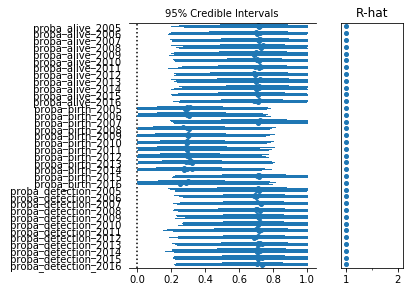

In [433]:
pm.forestplot(traces[0], varnames=vars_of_interest)

GridSpec(1, 2, width_ratios=[3, 1])

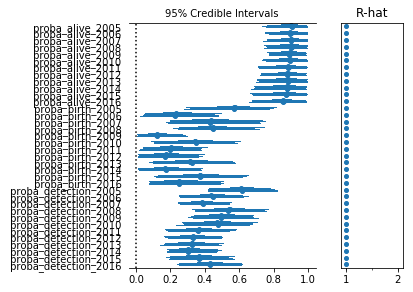

In [417]:
pm.forestplot(traces[25], varnames=vars_of_interest)

GridSpec(1, 2, width_ratios=[3, 1])

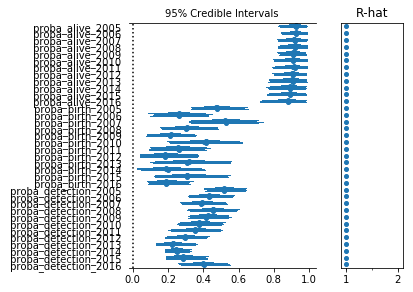

In [434]:
pm.forestplot(traces[52], varnames=vars_of_interest)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fabfca83780>,
      dtype=object)

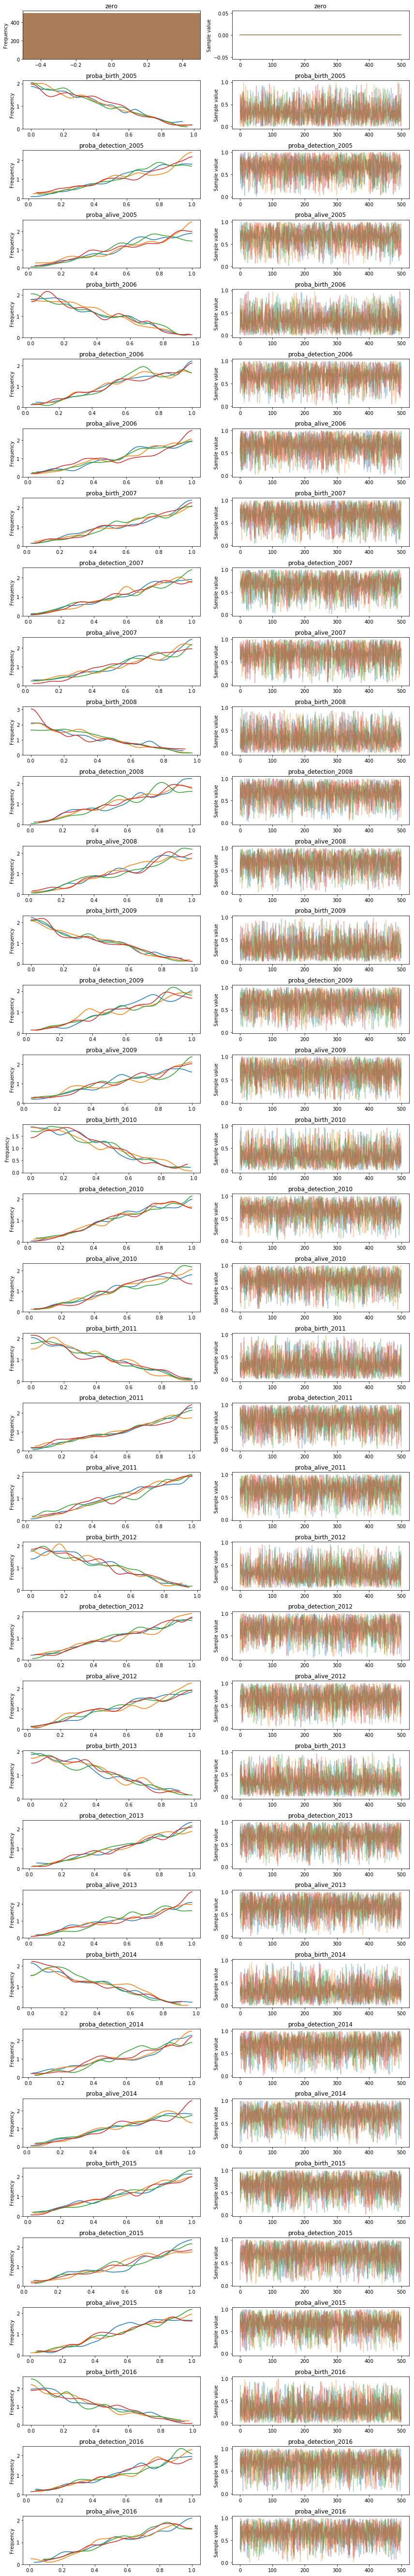

In [414]:
pm.traceplot(traces[0])

In [399]:
cleaned_matrix.iloc[1][STUDY_YEAR_COLUMNS]

2005    2
2006    1
2007    0
2008    0
2009    1
2010    1
2011    0
2012    0
2013    0
2014    0
2015    0
2016    0
Name: H004-1422, dtype: int64

### run_model

In [113]:
def run_model(year, data, sample_params):
    pymc_objects = {}
    
    # shared parameters
    
    pymc_objects[name('alive_alpha', year)] = pm.Normal(name('alive_alpha', year), mu=-10, sd=0.1)
    pymc_objects[name('age_greater_than_0_beta', year)] = pm.Normal(name('age_greater_than_0_beta', year), mu=0, sd=10)
    # pymc_objects[name('alive_proba', year)] = pm.Beta(name('alive_proba', year), alpha=4, beta=4)
    # pymc_objects[name('alive_proba_given_age_not_negative', year)] = pm.Beta(name('alive_proba_given_age_not_negative', year), alpha=4, beta=4)
    # pymc_objects[name('alive_proba_given_age_negative', year)] = pm.Constant(name('alive_proba_given_age_negative', year), c=0)
    pymc_objects[name('proba_birth_repr_active', year)] = pm.Beta(name('proba_birth_repr_active', year), alpha=4, beta=4)
    pymc_objects[name('proba_birth_not_repr_active', year)] = pm.Constant(name('proba_birth_not_repr_active', year), c=0)
    pymc_objects[name('detect_proba', year)] = pm.Beta(name('detect_proba', year), alpha=4, beta=4)
    pymc_objects['categ'] = pm.Normal('categ', mu=1000, sd=10)
    pymc_objects['no'] = pm.Normal('no', mu=-1000, sd=10)
    
    for i in data[str(year)].index:

        pymc_objects[name('age', year, indiv=i)] = age(year, i, known_birth_years, data)
        
        pymc_objects[name('alive', year, indiv=i)] = alive(
            year=year, 
            indiv=i, 
            data=data, 
            age=pymc_objects[name('age', year, indiv=i)],
            age_greater_than_0_beta=pymc_objects[name('age_greater_than_0_beta', year)], 
            alive_alpha=pymc_objects[name('alive_alpha', year)]
        )
        
        pymc_objects[name('repro_active', year, indiv=i)] = repro_active(
          pymc_objects[name('alive', year, indiv=i)],
          pymc_objects[name('age', year, indiv=i)]
        )
        
        pymc_objects[name('birth', year, indiv=i)] = birth(
            year=year,
            indiv=i,
            repr_active=pymc_objects[name('repro_active', year, indiv=i)],
            proba_birth_repr_active=pymc_objects[name('proba_birth_repr_active', year)], 
            proba_birth_not_repr_active=pymc_objects[name('proba_birth_not_repr_active', year)], 
            data=data
        )

        pymc_objects[name('detect', year, indiv=i)] = detect(
            year=year,
            indiv=i,
            data=data,
            proba_detect=pymc_objects[name('detect_proba', year)]
        )

        none_observed = pm.math.or_(
            pm.math.eq(pymc_objects[name('detect', year, i)], 0),
            pm.math.eq(pymc_objects[name('alive', year, i)], 0)
        )

        one_observed = pymc_objects[name('alive', year, i)] * \
            pymc_objects[name('detect', year, i)] * \
            pm.math.eq(pymc_objects[name('birth', year, i)], 0)
        
        two_observed = pymc_objects[name('repro_active', year, i)] * \
            pymc_objects[name('detect', year, i)] * \
            pymc_objects[name('birth', year, i)]

        pymc_objects['observed_' + i] = pm.Categorical(
            'observed_' + i,
            p=[
                pm.math.sigmoid(none_observed * pymc_objects['categ'] - pymc_objects['no']),
                pm.math.sigmoid(one_observed * pymc_objects['categ'] - pymc_objects['no']),
                pm.math.sigmoid(two_observed * pymc_objects['categ'] - pymc_objects['no'])
            ],
            observed=data.loc[i,str(year)]
        )
        
    return pm.sample(**sample_params)
    

In [82]:
traces_dict = {}

In [132]:
with pm.Model() as model_2005:    
    year = 2005
    data = cleaned_matrix
    

    traces_dict[year] = run_model(year, data, sample_params={
        'draws': 4000,
        'tune': 2000,
        'target_accept': 0.99
    })


Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
INFO:pymc3:CompoundStep
>NUTS: [age_2005_nan-new cow 2016, age_2005_H798-nan, age_2005_H788-nan, age_2005_H782-nan, age_2005_H753-nan, age_2005_H752-nan, age_2005_H748-nan, age_2005_H747-nan, age_2005_H745-nan, age_2005_H738-nan, age_2005_H731-nan, age_2005_H729-nan, age_2005_H728-nan, age_2005_H725-nan, age_2005_H721-nan, age_2005_H719-nan, age_2005_H716-nan, age_2005_H712-nan, age_2005_H711-nan, age_2005_H710-nan, age_2005_H706-nan, age_2005_H705-nan, age_2005_H704-nan, age_2005_H703-nan, age_2005_H700-nan, age_2005_H697-nan, age_2005_H694-nan, age_2005_H693-nan, age_2005_H692-nan, age_2005_H689-nan, age_2005_H687-nan, age_2005_H686-nan, age_2005_H684-nan, age_2005_H679-nan, age_2005_H673-nan, age_2005_H672-nan, age_2005_H648-nan, age_2005_H647-nan, age_2005_H638-nan, age_2005_H626-nan, age_2005_H624-nan, age_2005_H590-nan, age_2005_H584-nan, age_2005_H573-nan, age_2005_H565-

In [61]:
with pm.Model() as model_2006:
    year = 2006    

    traces_dict[year] = run_model(year, cleaned_matrix)


Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
INFO:pymc3:CompoundStep
>NUTS: [age_2006_nan-new cow 2016, age_2006_H798-nan, age_2006_H788-nan, age_2006_H782-nan, age_2006_H753-nan, age_2006_H752-nan, age_2006_H748-nan, age_2006_H747-nan, age_2006_H745-nan, age_2006_H738-nan, age_2006_H731-nan, age_2006_H729-nan, age_2006_H728-nan, age_2006_H725-nan, age_2006_H721-nan, age_2006_H719-nan, age_2006_H716-nan, age_2006_H712-nan, age_2006_H711-nan, age_2006_H710-nan, age_2006_H706-nan, age_2006_H705-nan, age_2006_H704-nan, age_2006_H703-nan, age_2006_H700-nan, age_2006_H697-nan, age_2006_H694-nan, age_2006_H693-nan, age_2006_H692-nan, age_2006_H689-nan, age_2006_H687-nan, age_2006_H686-nan, age_2006_H684-nan, age_2006_H679-nan, age_2006_H673-nan, age_2006_H672-nan, age_2006_H648-nan, age_2006_H647-nan, age_2006_H638-nan, age_2006_H626-nan, age_2006_H624-nan, age_2006_H590-nan, age_2006_H584-nan, age_2006_H573-nan, age_2006_H565-

In [62]:
with pm.Model() as model_2007:
    year = 2007    

    traces_dict[year] = run_model(year, cleaned_matrix)


Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
INFO:pymc3:CompoundStep
>NUTS: [age_2007_nan-new cow 2016, age_2007_H798-nan, age_2007_H788-nan, age_2007_H782-nan, age_2007_H753-nan, age_2007_H752-nan, age_2007_H748-nan, age_2007_H747-nan, age_2007_H745-nan, age_2007_H738-nan, age_2007_H731-nan, age_2007_H729-nan, age_2007_H728-nan, age_2007_H725-nan, age_2007_H721-nan, age_2007_H719-nan, age_2007_H716-nan, age_2007_H712-nan, age_2007_H711-nan, age_2007_H710-nan, age_2007_H706-nan, age_2007_H705-nan, age_2007_H704-nan, age_2007_H703-nan, age_2007_H700-nan, age_2007_H697-nan, age_2007_H694-nan, age_2007_H693-nan, age_2007_H692-nan, age_2007_H689-nan, age_2007_H687-nan, age_2007_H686-nan, age_2007_H684-nan, age_2007_H679-nan, age_2007_H673-nan, age_2007_H672-nan, age_2007_H648-nan, age_2007_H647-nan, age_2007_H638-nan, age_2007_H626-nan, age_2007_H624-nan, age_2007_H590-nan, age_2007_H584-nan, age_2007_H573-nan, age_2007_H565-

In [63]:
with pm.Model() as model_2008:
    year = 2008    

    traces_dict[year] = run_model(year, cleaned_matrix)


Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
INFO:pymc3:CompoundStep
>NUTS: [age_2008_nan-new cow 2016, age_2008_H798-nan, age_2008_H788-nan, age_2008_H782-nan, age_2008_H753-nan, age_2008_H752-nan, age_2008_H748-nan, age_2008_H747-nan, age_2008_H745-nan, age_2008_H738-nan, age_2008_H731-nan, age_2008_H729-nan, age_2008_H728-nan, age_2008_H725-nan, age_2008_H721-nan, age_2008_H719-nan, age_2008_H716-nan, age_2008_H712-nan, age_2008_H711-nan, age_2008_H710-nan, age_2008_H706-nan, age_2008_H705-nan, age_2008_H704-nan, age_2008_H703-nan, age_2008_H700-nan, age_2008_H697-nan, age_2008_H694-nan, age_2008_H693-nan, age_2008_H692-nan, age_2008_H689-nan, age_2008_H687-nan, age_2008_H686-nan, age_2008_H684-nan, age_2008_H679-nan, age_2008_H673-nan, age_2008_H672-nan, age_2008_H648-nan, age_2008_H647-nan, age_2008_H638-nan, age_2008_H626-nan, age_2008_H624-nan, age_2008_H590-nan, age_2008_H584-nan, age_2008_H573-nan, age_2008_H565-

In [64]:
with pm.Model() as model_2009:
    year = 2009
    
    traces_dict[year] = run_model(year=year, data=cleaned_matrix)


Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
INFO:pymc3:CompoundStep
>NUTS: [age_2009_nan-new cow 2016, age_2009_H798-nan, age_2009_H788-nan, age_2009_H782-nan, age_2009_H753-nan, age_2009_H752-nan, age_2009_H748-nan, age_2009_H747-nan, age_2009_H745-nan, age_2009_H738-nan, age_2009_H731-nan, age_2009_H729-nan, age_2009_H728-nan, age_2009_H725-nan, age_2009_H721-nan, age_2009_H719-nan, age_2009_H716-nan, age_2009_H712-nan, age_2009_H711-nan, age_2009_H710-nan, age_2009_H706-nan, age_2009_H705-nan, age_2009_H704-nan, age_2009_H703-nan, age_2009_H700-nan, age_2009_H697-nan, age_2009_H694-nan, age_2009_H693-nan, age_2009_H692-nan, age_2009_H689-nan, age_2009_H687-nan, age_2009_H686-nan, age_2009_H684-nan, age_2009_H679-nan, age_2009_H673-nan, age_2009_H672-nan, age_2009_H648-nan, age_2009_H647-nan, age_2009_H638-nan, age_2009_H626-nan, age_2009_H624-nan, age_2009_H590-nan, age_2009_H584-nan, age_2009_H573-nan, age_2009_H565-

In [65]:
with pm.Model() as model_2010:
    year = 2010
    traces_dict[year] = run_model(year=year, data=cleaned_matrix)


Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
INFO:pymc3:CompoundStep
>NUTS: [age_2010_nan-new cow 2016, age_2010_H798-nan, age_2010_H788-nan, age_2010_H782-nan, age_2010_H753-nan, age_2010_H752-nan, age_2010_H748-nan, age_2010_H747-nan, age_2010_H745-nan, age_2010_H738-nan, age_2010_H731-nan, age_2010_H729-nan, age_2010_H728-nan, age_2010_H725-nan, age_2010_H721-nan, age_2010_H719-nan, age_2010_H716-nan, age_2010_H712-nan, age_2010_H711-nan, age_2010_H710-nan, age_2010_H706-nan, age_2010_H705-nan, age_2010_H704-nan, age_2010_H703-nan, age_2010_H700-nan, age_2010_H697-nan, age_2010_H694-nan, age_2010_H693-nan, age_2010_H692-nan, age_2010_H689-nan, age_2010_H687-nan, age_2010_H686-nan, age_2010_H684-nan, age_2010_H679-nan, age_2010_H673-nan, age_2010_H672-nan, age_2010_H648-nan, age_2010_H647-nan, age_2010_H638-nan, age_2010_H626-nan, age_2010_H624-nan, age_2010_H590-nan, age_2010_H584-nan, age_2010_H573-nan, age_2010_H565-

In [66]:
with pm.Model() as model_2011:
    year = 2011
    traces_dict[year] = run_model(year=year, data=cleaned_matrix)


Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
INFO:pymc3:CompoundStep
>NUTS: [age_2011_nan-new cow 2016, age_2011_H798-nan, age_2011_H788-nan, age_2011_H782-nan, age_2011_H753-nan, age_2011_H752-nan, age_2011_H748-nan, age_2011_H747-nan, age_2011_H745-nan, age_2011_H738-nan, age_2011_H731-nan, age_2011_H729-nan, age_2011_H728-nan, age_2011_H725-nan, age_2011_H721-nan, age_2011_H719-nan, age_2011_H716-nan, age_2011_H712-nan, age_2011_H711-nan, age_2011_H710-nan, age_2011_H706-nan, age_2011_H705-nan, age_2011_H704-nan, age_2011_H703-nan, age_2011_H700-nan, age_2011_H697-nan, age_2011_H694-nan, age_2011_H693-nan, age_2011_H692-nan, age_2011_H689-nan, age_2011_H687-nan, age_2011_H686-nan, age_2011_H684-nan, age_2011_H679-nan, age_2011_H673-nan, age_2011_H672-nan, age_2011_H648-nan, age_2011_H647-nan, age_2011_H638-nan, age_2011_H626-nan, age_2011_H624-nan, age_2011_H590-nan, age_2011_H584-nan, age_2011_H573-nan, age_2011_H565-

In [67]:
with pm.Model() as model_2012:
    year = 2012
    traces_dict[year] = run_model(year=year, data=cleaned_matrix)


Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
INFO:pymc3:CompoundStep
>NUTS: [age_2012_nan-new cow 2016, age_2012_H798-nan, age_2012_H788-nan, age_2012_H782-nan, age_2012_H753-nan, age_2012_H752-nan, age_2012_H748-nan, age_2012_H747-nan, age_2012_H745-nan, age_2012_H738-nan, age_2012_H731-nan, age_2012_H729-nan, age_2012_H728-nan, age_2012_H725-nan, age_2012_H721-nan, age_2012_H719-nan, age_2012_H716-nan, age_2012_H712-nan, age_2012_H711-nan, age_2012_H710-nan, age_2012_H706-nan, age_2012_H705-nan, age_2012_H704-nan, age_2012_H703-nan, age_2012_H700-nan, age_2012_H697-nan, age_2012_H694-nan, age_2012_H693-nan, age_2012_H692-nan, age_2012_H689-nan, age_2012_H687-nan, age_2012_H686-nan, age_2012_H684-nan, age_2012_H679-nan, age_2012_H673-nan, age_2012_H672-nan, age_2012_H648-nan, age_2012_H647-nan, age_2012_H638-nan, age_2012_H626-nan, age_2012_H624-nan, age_2012_H590-nan, age_2012_H584-nan, age_2012_H573-nan, age_2012_H565-

In [68]:
with pm.Model() as model_2013:
    year = 2013
    traces_dict[year] = run_model(year=year, data=cleaned_matrix)


Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
INFO:pymc3:CompoundStep
>NUTS: [age_2013_nan-new cow 2016, age_2013_H798-nan, age_2013_H788-nan, age_2013_H782-nan, age_2013_H753-nan, age_2013_H752-nan, age_2013_H748-nan, age_2013_H747-nan, age_2013_H745-nan, age_2013_H738-nan, age_2013_H731-nan, age_2013_H729-nan, age_2013_H728-nan, age_2013_H725-nan, age_2013_H721-nan, age_2013_H719-nan, age_2013_H716-nan, age_2013_H712-nan, age_2013_H711-nan, age_2013_H710-nan, age_2013_H706-nan, age_2013_H705-nan, age_2013_H704-nan, age_2013_H703-nan, age_2013_H700-nan, age_2013_H697-nan, age_2013_H694-nan, age_2013_H693-nan, age_2013_H692-nan, age_2013_H689-nan, age_2013_H687-nan, age_2013_H686-nan, age_2013_H684-nan, age_2013_H679-nan, age_2013_H673-nan, age_2013_H672-nan, age_2013_H648-nan, age_2013_H647-nan, age_2013_H638-nan, age_2013_H626-nan, age_2013_H624-nan, age_2013_H590-nan, age_2013_H584-nan, age_2013_H573-nan, age_2013_H565-

In [69]:
with pm.Model() as model_2014:

    year = 2014
    traces_dict[year] = run_model(year=year, data=cleaned_matrix)


Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
INFO:pymc3:CompoundStep
>NUTS: [age_2014_nan-new cow 2016, age_2014_H798-nan, age_2014_H788-nan, age_2014_H782-nan, age_2014_H753-nan, age_2014_H752-nan, age_2014_H748-nan, age_2014_H747-nan, age_2014_H745-nan, age_2014_H738-nan, age_2014_H731-nan, age_2014_H729-nan, age_2014_H728-nan, age_2014_H725-nan, age_2014_H721-nan, age_2014_H719-nan, age_2014_H716-nan, age_2014_H712-nan, age_2014_H711-nan, age_2014_H710-nan, age_2014_H706-nan, age_2014_H705-nan, age_2014_H704-nan, age_2014_H703-nan, age_2014_H700-nan, age_2014_H697-nan, age_2014_H694-nan, age_2014_H693-nan, age_2014_H692-nan, age_2014_H689-nan, age_2014_H687-nan, age_2014_H686-nan, age_2014_H684-nan, age_2014_H679-nan, age_2014_H673-nan, age_2014_H672-nan, age_2014_H648-nan, age_2014_H647-nan, age_2014_H638-nan, age_2014_H626-nan, age_2014_H624-nan, age_2014_H590-nan, age_2014_H584-nan, age_2014_H573-nan, age_2014_H565-

In [70]:
with pm.Model() as model_2015:

    year = 2015
    traces_dict[year] = run_model(year=year, data=cleaned_matrix)


Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
INFO:pymc3:CompoundStep
>NUTS: [age_2015_nan-new cow 2016, age_2015_H798-nan, age_2015_H788-nan, age_2015_H782-nan, age_2015_H753-nan, age_2015_H752-nan, age_2015_H748-nan, age_2015_H747-nan, age_2015_H745-nan, age_2015_H738-nan, age_2015_H731-nan, age_2015_H729-nan, age_2015_H728-nan, age_2015_H725-nan, age_2015_H721-nan, age_2015_H719-nan, age_2015_H716-nan, age_2015_H712-nan, age_2015_H711-nan, age_2015_H710-nan, age_2015_H706-nan, age_2015_H705-nan, age_2015_H704-nan, age_2015_H703-nan, age_2015_H700-nan, age_2015_H697-nan, age_2015_H694-nan, age_2015_H693-nan, age_2015_H692-nan, age_2015_H689-nan, age_2015_H687-nan, age_2015_H686-nan, age_2015_H684-nan, age_2015_H679-nan, age_2015_H673-nan, age_2015_H672-nan, age_2015_H648-nan, age_2015_H647-nan, age_2015_H638-nan, age_2015_H626-nan, age_2015_H624-nan, age_2015_H590-nan, age_2015_H584-nan, age_2015_H573-nan, age_2015_H565-

### Results

In [98]:
cleaned_matrix.index

Index(['H002-3229', 'H004-1422', 'H008-1417', 'H009-1419', 'H035-2088',
       'H042-1451', 'H044-1424', 'H065-7002', 'H067-7014', 'H102-nan',
       ...
       'H738-nan', 'H745-nan', 'H747-nan', 'H748-nan', 'H752-nan', 'H753-nan',
       'H782-nan', 'H788-nan', 'H798-nan', 'nan-new cow 2016'],
      dtype='object', length=115)

In [116]:
def vars_for_year(year):
    return [
        'proba_birth_repr_active_' + str(year),
        'proba_birth_not_repr_active_' + str(year),
        'detect_proba_' + str(year),
        'age_greater_than_0_beta_' + str(year),
        'alive_alpha_' + str(year),
        name('age', year, 'H002-3229')
    ]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fac6293f160>,
      dtype=object)

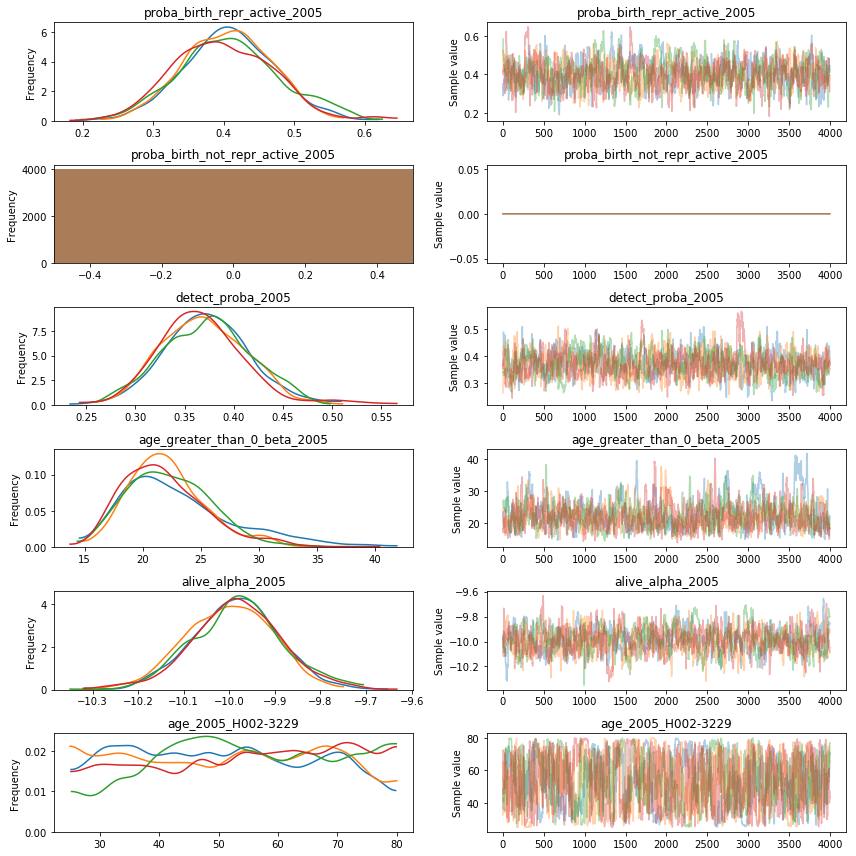

In [117]:
pm.traceplot(traces_dict[2005], varnames=vars_for_year(2005))

In [118]:
pm.summary(traces_dict[2005], varnames=vars_for_year(2005))

mean         sd  mc_error    hpd_2.5  \
proba_birth_repr_active_2005       0.405113   0.067139  0.002611   0.268182   
proba_birth_not_repr_active_2005   0.000000   0.000000  0.000000   0.000000   
detect_proba_2005                  0.370546   0.044454  0.001942   0.284037   
age_greater_than_0_beta_2005      22.422710   4.031199  0.205578  15.935259   
alive_alpha_2005                  -9.989023   0.095692  0.003642 -10.178488   
age_2005_H002-3229                52.918587  15.412525  0.750706  28.169800   

                                   hpd_97.5       n_eff      Rhat  
proba_birth_repr_active_2005       0.530592  587.772471  1.001882  
proba_birth_not_repr_active_2005   0.000000         NaN       NaN  
detect_proba_2005                  0.456137  490.674175  1.001498  
age_greater_than_0_beta_2005      30.974710  330.147678  1.010737  
alive_alpha_2005                  -9.799336  537.825528  1.004738  
age_2005_H002-3229                79.736167  336.778360  1.005862

In [126]:
len(traces_dict[2005])

4000

In [124]:

# display the total number and percentage of divergent
divergent = traces_dict[2005]['diverging']
print('Number of Divergent %d' % divergent.nonzero()[0].size)
divperc = divergent.nonzero()[0].size / len(traces_dict[2005]) * 100
print('Percentage of Divergent %.1f' % divperc)



Number of Divergent 15890
Percentage of Divergent 397.2


In [131]:
divergent.nonzero()[0].size

15890

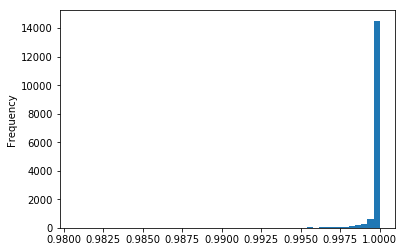

In [121]:
pd.Series(logistic(traces_dict[2005]['age_greater_than_0_beta_2005'] + traces_dict[2005]['alive_alpha_2005'])).plot.hist(bins=50)

In [ ]:
pm.forestplot(traces_dict[2005], varnames=vars_for_year(2005))

In [66]:
pm.forestplot(traces_dict[2006], varnames=vars_for_year(2006))

GridSpec(1, 2, width_ratios=[3, 1])

In [68]:
pm.forestplot(traces_dict[2007], varnames=vars_for_year(2007))

GridSpec(1, 2, width_ratios=[3, 1])

In [70]:
pm.forestplot(traces_dict[2008], varnames=vars_for_year(2008))

GridSpec(1, 2, width_ratios=[3, 1])

In [75]:
pm.forestplot(traces_dict[2009], varnames=vars_for_year(2009))

GridSpec(1, 2, width_ratios=[3, 1])

In [77]:
pm.forestplot(traces_dict[2010], varnames=vars_for_year(2010))

GridSpec(1, 2, width_ratios=[3, 1])

GridSpec(1, 2, width_ratios=[3, 1])

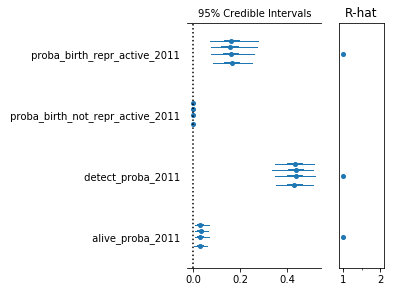

In [80]:
pm.forestplot(traces_dict[2011], varnames=vars_for_year(2011))

In [82]:
pm.forestplot(traces_dict[2012], varnames=vars_for_year(2012))

GridSpec(1, 2, width_ratios=[3, 1])

In [86]:
pm.forestplot(traces_dict[2013], varnames=vars_for_year(2013))

GridSpec(1, 2, width_ratios=[3, 1])

In [87]:
pm.forestplot(traces_dict[2014], varnames=vars_for_year(2014))

GridSpec(1, 2, width_ratios=[3, 1])

GridSpec(1, 2, width_ratios=[3, 1])

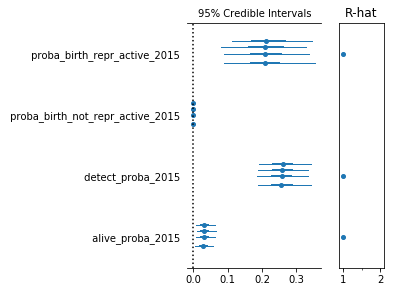

In [88]:
pm.forestplot(traces_dict[2015], varnames=vars_for_year(2015))

In [93]:
list(traces_dict.keys())

[2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015]

In [95]:
np.linspace(0.05, 0.2, 10)

array([0.05      , 0.06666667, 0.08333333, 0.1       , 0.11666667,
       0.13333333, 0.15      , 0.16666667, 0.18333333, 0.2       ])

In [105]:
traces_dict[2005]['proba_birth_repr_active_' + str(2005)].std()

0.06856748645480429

In [112]:
np.percentile(traces_dict[2015]['proba_birth_repr_active_' + str(2015)], 97.5) - np.percentile(traces_dict[2015]['proba_birth_repr_active_' + str(2015)], 2.5)

0.2549885304888708

In [125]:
def plot_credible_intervals_over_years(traces_dict, var_prefix, title, upper_perc=97.5, lower_perc=2.5, ylim=(0,0.5)):
    fig = plt.figure()
    plt.title(title)

    x = list(traces_dict.keys())
    y = [traces_dict[i][var_prefix + str(i)].mean() for i in x]

    y_err = []
    for i in x:

        percentile_high = np.percentile(traces_dict[i][var_prefix + str(i)], upper_perc)
        percentile_low = np.percentile(traces_dict[i][var_prefix + str(i)], lower_perc)
        y_err.append((percentile_high - percentile_low) / 2)

    plt.errorbar(x, y, yerr=y_err)
    plt.ylim(ylim)

In [129]:
plot_credible_intervals_over_years(
    traces_dict, 
    var_prefix='proba_birth_repr_active_', 
    title='95% Credible Intervals of RAFs Birth Rates',
    ylim=(0,0.7)
)

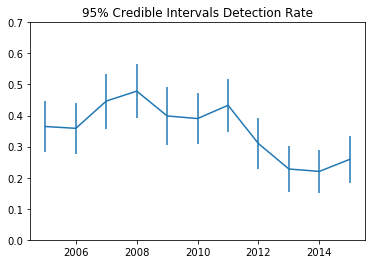

In [132]:
plot_credible_intervals_over_years(
    traces_dict, 
    var_prefix='detect_proba_', 
    title='95% Credible Intervals Detection Rate',
    ylim=(0,0.7)
)

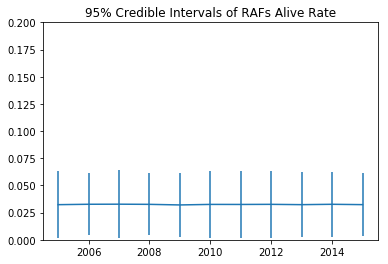

In [135]:
plot_credible_intervals_over_years(
    traces_dict, 
    var_prefix='alive_proba_', 
    title='95% Credible Intervals of RAFs Alive Rate',
    ylim=(0,0.2)
)

In [107]:
y

[0.4021001935986439,
 0.18047350084718933,
 0.27729004957298176,
 0.23128030691637969,
 0.17461972730446643,
 0.23383544651499308,
 0.1635406899045405,
 0.1696652695273724,
 0.2212221545298649,
 0.1441696301508034,
 0.21470100740379525]

In [115]:
y_err

[0.13461400391076375,
 0.10074006983347472,
 0.10647608740071075,
 0.10122896669857717,
 0.10001219681621061,
 0.11383325444984838,
 0.09571174164421878,
 0.10633504639339719,
 0.1339106405229926,
 0.1107943275629151,
 0.1274942652444354]